<div style="text-align: center;">
<h1>Reel Realities: How Gender and Age Shape Success Across Box Office and Streaming Platforms</h1>
</div>

### <u>Imports</u>

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
import re
import numpy as np
import os
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler, MinMaxScaler

### 1. <u>Data cleaning and pre-processing</u>

#### 1.1 CMU Dataset

We will use three files of the CMU dataset:
1. "plot_summaries.txt" gives us the plots of the movies.
2. "movie.metadata.tsv" gives us information about the languages, countries, and genres of the movies.
3. "character.metadata.tsv" gives us information about actors and the characters they play.

In [4]:
path_plot_summaries = os.path.join("data","CMU","plot_summaries.txt")
plot_summaries_df = pd.read_csv(path_plot_summaries, delimiter="\t", names = ["Wikipedia_movie_ID", "Plot Summaries"])

print(f"The plot summaries dataframe has {len(plot_summaries_df):,} values.")

The plot summaries dataframe has 42,303 values.


In [5]:
null_id = plot_summaries_df["Wikipedia_movie_ID"].isnull().sum()
empty_id = plot_summaries_df[plot_summaries_df["Wikipedia_movie_ID"] == ""]["Wikipedia_movie_ID"].sum()
null_plot = plot_summaries_df["Plot Summaries"].isnull().sum()
empty_plot = plot_summaries_df[plot_summaries_df["Plot Summaries"] == ""]["Plot Summaries"].sum()

In [6]:
print(f"Number of null values in 'Wikipedia_movie_ID': {null_id}")
print(f"Number of empty values in 'Wikipedia_movie_ID': {empty_id}")
print(f"Number of null values in 'Plot Summaries': {null_plot}")
print(f"Number of empty values in 'Plot Summaries': {empty_plot}")

Number of null values in 'Wikipedia_movie_ID': 0
Number of empty values in 'Wikipedia_movie_ID': 0
Number of null values in 'Plot Summaries': 0
Number of empty values in 'Plot Summaries': 0


In [7]:
column_names = ["Wikipedia_movie_ID",
                "Freebase_movie_ID",
                "Movie_name",
                "Movie_release_date",
                "Movie_box_office_revenue",
                "Movie_runtime",
                "Movie_languages",
                "Movie_countries",
                "Movie_genres"]

movie_metadata_df = pd.read_csv("data/CMU/movie.metadata.tsv", delimiter='\t', names = column_names)
print(f"The movie metadata dataframe has {len(movie_metadata_df):,} values.")

The movie metadata dataframe has 81,741 values.


In [8]:
movie_metadata_df["Movie_name"] = (movie_metadata_df["Movie_name"]
                    .str.strip()  #Remove leading/trailing whitespace
                    .str.lower()  #Convert to lowercase
                    .replace("", np.nan)  #Replace empty strings with NaN
                   )

In [9]:
# Movie languages, countries, and genres are formatted as a dictionary, but they are actually a string.
# We convert them to comma spereated strings. 
movie_metadata_df["Movie_languages"] = movie_metadata_df["Movie_languages"].apply(ast.literal_eval)
movie_metadata_df["Movie_languages"] = movie_metadata_df["Movie_languages"].apply(lambda x: ', '.join(x.values()))

movie_metadata_df["Movie_countries"] = movie_metadata_df["Movie_countries"].apply(ast.literal_eval)
movie_metadata_df["Movie_countries"] = movie_metadata_df["Movie_countries"].apply(lambda x: ', '.join(x.values()))

movie_metadata_df["Movie_genres"] = movie_metadata_df["Movie_genres"].apply(ast.literal_eval)
movie_metadata_df["Movie_genres"] = movie_metadata_df["Movie_genres"].apply(lambda x: ', '.join(x.values()))

In [10]:
# Cleaning
def clean_string_list(lst):
    # Check if lst is a list
    if isinstance(lst, list):
        return [s.strip().lower() if isinstance(s, str) and s.strip() != "" else np.nan for s in lst]
    elif isinstance(lst, str): 
        return lst.strip().lower()
    else:
        return np.nan 

movie_metadata_df["Movie_languages"] = movie_metadata_df["Movie_languages"].apply(clean_string_list)
movie_metadata_df["Movie_countries"] = movie_metadata_df["Movie_countries"].apply(clean_string_list)
movie_metadata_df["Movie_genres"] = movie_metadata_df["Movie_genres"].apply(clean_string_list)

In [11]:
#There are inconsistencies in the date format: some rows have the date as year only, others as year-month, and some as year-month-day. We convert them all to the year format only since the month and day are not relevant to our analysis.
full_date_pattern = r'^\d{4}-\d{2}-\d{2}$' #Matches YYYY-MM-DD
year_month_pattern = r'^\d{4}-\d{2}$' #Matches YYYY-MM
year_only_pattern = r'^\d{4}$' #Matches YYYY

def identify_pattern(date):
    if pd.isna(date):
        return "Missing"
    elif re.match(full_date_pattern, date):
        return "Full Date (YYYY-MM-DD)"
    elif re.match(year_month_pattern, date):
        return "Year & Month Date (YYYY-MM)"
    elif re.match(year_only_pattern, date):
        return "Year Only (YYYY)"
    else:
        return "Other"

movie_metadata_df["Pattern"] = movie_metadata_df["Movie_release_date"].apply(identify_pattern)
pattern_summary = movie_metadata_df.groupby("Pattern").size().reset_index(name="Count")

print("Pattern Summary:")
print(pattern_summary)

Pattern Summary:
                       Pattern  Count
0       Full Date (YYYY-MM-DD)  39373
1                      Missing   6902
2  Year & Month Date (YYYY-MM)   3294
3             Year Only (YYYY)  32172


In [12]:
movie_metadata_df["Movie_release_date"] = movie_metadata_df["Movie_release_date"].apply(lambda x: str(x)[:4] if pd.notnull(x) else None)
movie_metadata_df = movie_metadata_df.drop(columns=["Pattern"])

In [13]:
n_null_movie_metadata = ((movie_metadata_df.isnull().sum() / len(movie_metadata_df)) * 100).apply(lambda x: f"{x:,.2f}%")

print(
    f"Percentage of null values per column:\n"
    f"movie_metadata_df:\n{n_null_movie_metadata}"
)

Percentage of null values per column:
movie_metadata_df:
Wikipedia_movie_ID           0.00%
Freebase_movie_ID            0.00%
Movie_name                   0.00%
Movie_release_date           8.44%
Movie_box_office_revenue    89.72%
Movie_runtime               25.02%
Movie_languages              0.00%
Movie_countries              0.00%
Movie_genres                 0.00%
dtype: object


In [14]:
character_metadata_path = os.path.join("data","CMU","character.metadata.tsv")
character_metadata = pd.read_csv(character_metadata_path, delimiter="\t", header = None)
character_metadata.columns = [
    'Wikipedia_movie_ID', 
    'Freebase_movie_ID', 
    'Movie_release_date', 
    'Character_name', 
    'Actor_date_of_birth', 
    'Actor_gender', 
    'Actor_height', 
    'Actor_ethnicity', 
    'Actor_name', 
    'Actor_age_at_movie_release', 
    'Freebase_character_actor_map_ID', 
    'Freebase_character_ID', 
    'Freebase_actor_ID'
]

In [15]:
character_metadata['Actor_name']= character_metadata['Actor_name'].fillna('unknown')
character_metadata["Actor_name"] = character_metadata["Actor_name"].str.lower()

# Ensures that the date columns are correctly interpreted as datetime objects in pandas. 
character_metadata['Movie_release_date'] = pd.to_datetime(character_metadata['Movie_release_date'], errors='coerce').dt.date
character_metadata['Actor_date_of_birth'] = pd.to_datetime(character_metadata['Actor_date_of_birth'], errors='coerce').dt.date

# Drop rows where 'Movie_release_date' or 'Actor_date_of_birth' is NaT
character_metadata.dropna(subset=['Movie_release_date', 'Actor_date_of_birth'], inplace=True)

# Calculate Actor_age_at_movie_release if missing and data is available
character_metadata['Actor_age_at_movie_release'] = character_metadata.apply(
    lambda row: (row['Movie_release_date'] - row['Actor_date_of_birth']).days // 365 if pd.isnull(row['Actor_age_at_movie_release']) else row['Actor_age_at_movie_release'],
    axis=1
)

#Drop unnecessary columns , heere the actors' heights
character_metadata.drop(columns=['Actor_height', 'Actor_ethnicity', 'Character_name'], inplace=True)


In [16]:
print(f"Movies without actor gender data: {character_metadata['Actor_gender'].isnull().sum()}") 

Movies without actor gender data: 892


We therefore drop the mvies with no information the gender of the actors.

In [17]:
character_metadata.dropna(subset=['Actor_gender'], inplace=True)

Now, let's groupe the actors together by creating a *Cast* column on the *movie_metadata_df*. 

In [18]:
cast_per_movie = character_metadata.groupby('Freebase_movie_ID')['Actor_name'].apply(lambda x: ', '.join(x)).reset_index()
cast_per_movie = cast_per_movie.rename(columns={'Actor_name': 'Cast'})

movie_metadata_df = movie_metadata_df.merge(cast_per_movie, on='Freebase_movie_ID', how='left')

In [19]:
missing_cast_count = movie_metadata_df["Cast"].isna().sum()
total_movies = len(movie_metadata_df)
print(f"Movies without actor data: {missing_cast_count} out of {total_movies} ({missing_cast_count / total_movies * 100:.2f}%)")

Movies without actor data: 48556 out of 81741 (59.40%)


We decide to drop the movies without actor data since it is one of the most important data of ur study. 

In [20]:
movie_metadata_df = movie_metadata_df.dropna(subset = ['Cast'])

In [21]:
# Create columns for male, female actor counts
actor_counts = character_metadata.groupby('Freebase_movie_ID')['Actor_gender'].value_counts().unstack(fill_value=0)
actor_counts = actor_counts.rename(columns={'M': 'Male_actors', 'F': 'Female_actors'})

# Ensure all columns are present (set missing columns to 0 if necessary)
for col in ['Male_actors', 'Female_actors']:
    if col not in actor_counts.columns:
        actor_counts[col] = 0

actor_counts = actor_counts.reset_index()

# Merge actor counts with the movie_metadata_df DataFrame
movie_metadata_df = movie_metadata_df.merge(actor_counts, on='Freebase_movie_ID', how='left')

# Fill NaN values with 0 
movie_metadata_df[['Male_actors', 'Female_actors']] = movie_metadata_df[['Male_actors', 'Female_actors']].fillna(0)

In [22]:
# Calculate the percentage of female actors in each movie and round to two decimal places
movie_metadata_df['Female_actor_percentage'] = (
    (movie_metadata_df['Female_actors'] / 
     (movie_metadata_df['Female_actors'] + movie_metadata_df['Male_actors'])) * 100
).round(2)

#### 1.2 IMDB Dataset

We will use two IMDB datasets to decribe movies:
1. "title.ratings.tsv" gives us the ratings of the movies as voted by viewers. 
2. "title.basics.tsv", indexes into "title.ratings.tsv" using a alphanumeric unique identifier of the title. It gives general information about the movie such as runtime, release date and adult rating.
3. "title.crew.tsv", indexes into the previous two using the same alphanumeric unique identifier of the title. It gives information on the directors and writers of the movie.

Reference:
Internet Movie Database. (2024). IMDb non-commercial datasets. Retrieved from https://developer.imdb.com/non-commercial-datasets/

In [23]:
# Loading the datasets. Null values are represented using "\N".
IMDB_ratings_path = os.path.join("data","IMDB","title.ratings.tsv")
IMDB_ratings_df = pd.read_csv(IMDB_ratings_path, delimiter="\t", na_values="\\N", names=["tconst", "Average_ratings", "Num_votes"], low_memory= False)

IMDB_titles_path = os.path.join("data","IMDB","title.basics.tsv")
column_names_basics = ["tconst",
                       "Title_type",
                       "Primary_title",
                       "Original_title",
                       "Is_adult",
                       "Start_year",
                       "End_year",
                       "Movie_runtime",
                       "Movie_genres"]
IMDB_basics_df = pd.read_csv(IMDB_titles_path, delimiter="\t", na_values="\\N", low_memory=False, names=column_names_basics)

IMDB_crew_path = os.path.join("data","IMDB","title.crew.tsv")
IMDB_crew_df = pd.read_csv(IMDB_crew_path, delimiter="\t", na_values="\\N", low_memory=False, names=["tconst", "Directors", "Writers"])

In [24]:
# Checking the lengths of the datasets
print(f"Length of IMDB_ratings_df: {len(IMDB_ratings_df):,}\n"
      f"Length of IMDB_basics_df: {len(IMDB_basics_df):,}\n"
      f"Length of IMDB_crew_df: {len(IMDB_crew_df):,}")

Length of IMDB_ratings_df: 1,498,616
Length of IMDB_basics_df: 11,235,768
Length of IMDB_crew_df: 10,571,537


Before dealing with the null values we will merge the dataframes together using the alphanumeric unique identifier.

In [25]:
# Merging all three datasets.
IMDB_merged_df = pd.merge(IMDB_ratings_df, IMDB_basics_df, how="inner", left_on="tconst", right_on="tconst")
IMDB_merged_df = pd.merge(IMDB_merged_df, IMDB_crew_df, how="inner", on="tconst")

print(f"The resulting merged dataframe has length: {len(IMDB_merged_df):,}.")
print(f"{len(IMDB_ratings_df)-len(IMDB_merged_df):,} rows were lost in the merging process.")

The resulting merged dataframe has length: 1,484,730.
13,886 rows were lost in the merging process.


We can see we do not lose a lot of rows with respect to the IMDB_ratings_df dataframe.

Next, we look at titleType. These dataframes do not only have movies but also short movies, tv shows, episodes. The next step is thus to filter only movies.

In [26]:
# Filtering movies from the list of titles.
IMDB_merged_df = IMDB_merged_df[IMDB_merged_df["Title_type"] == "movie"]

print(f"There are {len(IMDB_merged_df):,} movies in the resulting dataframe.")

There are 319,293 movies in the resulting dataframe.


Formatting the strings appropriately.

In [27]:
IMDB_merged_df["Original_title"] = IMDB_merged_df["Original_title"].apply(clean_string_list)
IMDB_merged_df["Primary_title"] = IMDB_merged_df["Primary_title"].apply(clean_string_list)

We can now look at null values in the merged IMDB dataframe.

In [28]:
# Checking the percentage of null values in the dataset.
n_null_IMDB = ((IMDB_merged_df.isnull().sum() / len(IMDB_merged_df)) * 100).apply(lambda x: f"{x:,.2f}%")

print(
    f"Percentage of null values per column:\n"
    f"IMDB_ratings_df:\n{n_null_IMDB}"
)

Percentage of null values per column:
IMDB_ratings_df:
tconst               0.00%
Average_ratings      0.00%
Num_votes            0.00%
Title_type           0.00%
Primary_title        0.00%
Original_title       0.00%
Is_adult             0.00%
Start_year           0.01%
End_year           100.00%
Movie_runtime        9.98%
Movie_genres         3.26%
Directors            0.98%
Writers             12.30%
dtype: object


The end year is always missing. Other than that the proportion of missing values is very small (< 12%). End year does not have any useful information for our intended analysis and can thus be dropped. We can also drop the titleType column since we know they are all movies after the filtering that was done above.

In [29]:
# Dropping unnecessary columns.
IMDB_merged_df = IMDB_merged_df.drop(columns=["End_year", "Title_type"], axis=1)

print(f"The resulting dataframe has {len(IMDB_merged_df):,} rows.")

The resulting dataframe has 319,293 rows.


We will use ratings from the IMDB dataset during our study. However, these ratings are based on viewer votes. Initially we thought of discarding rows with too few votes. However, there could be a link between number of votes and number of views of a movie (although definitely not a direct one). We thus decided to keep all rows for the analysis.

#### 1.3 Merging the datasets

##### 1.3.1 Merging IMDB and CMU Movies

In [30]:
# Merging on the original title.
merge1 = pd.merge(IMDB_merged_df, movie_metadata_df, how="inner", left_on="Original_title", right_on="Movie_name")
# Merging on the primary title.
merge2 = pd.merge(IMDB_merged_df, movie_metadata_df, how="inner", left_on="Primary_title", right_on="Movie_name")

# Concatenating and dropping duplicates that appear from movies with the same Original_title and Primary_title.
movie_df = pd.concat([merge1, merge2]).drop_duplicates(subset=["tconst"]).reset_index(drop=True)

print(f"The resulting dataframe has {len(movie_df):,} rows.")

The resulting dataframe has 38,550 rows.


Some columns appear twice. Let's take a look at the proportion of null values in each duplicate column.

In [31]:
n_null_movie = (movie_df.isnull().sum()/len(movie_df)).apply(lambda x:f"{x:.2%}")

print(f"Percentage of null values per column:\n{n_null_movie}")

Percentage of null values per column:
tconst                       0.00%
Average_ratings              0.00%
Num_votes                    0.00%
Primary_title                0.00%
Original_title               0.00%
Is_adult                     0.00%
Start_year                   0.00%
Movie_runtime_x              5.50%
Movie_genres_x               1.41%
Directors                    0.43%
Writers                      5.31%
Wikipedia_movie_ID           0.00%
Freebase_movie_ID            0.00%
Movie_name                   0.00%
Movie_release_date           0.00%
Movie_box_office_revenue    73.83%
Movie_runtime_y             10.74%
Movie_languages              0.00%
Movie_countries              0.00%
Movie_genres_y               0.00%
Cast                         0.00%
Female_actors                0.00%
Male_actors                  0.00%
Female_actor_percentage      0.00%
dtype: object


We can see:
- Movie_runtime_x and Movie_runtime_y have 6.02% and 11.58% missing values respectively. We will combine the non null values from both these columns into a new column called runtimeMinutes and then drop the previous two columns. 
- Movie_genres_x has 1.54% missing values against 0.00% missing values for Movie_genres_y. Furthermore Movie_genres_y is from the CMU dataset and seems more complete. We will thus drop the genres_x column.

In [32]:
# Combining all non-null values from Movie_runtime_x and Movie_runtime_y into runtimeMinutes.
movie_df["Movie_runtime"] = movie_df["Movie_runtime_x"].combine_first(movie_df["Movie_runtime_y"])

# Dropping the unnecessary columns.
movie_df.drop(columns=["Movie_runtime_x", "Movie_runtime_y", "Movie_genres_x"], inplace=True)

Let's now see if Movie_name, originalTitle and primaryTitle are all necessary or if there are any redundancies.

In [33]:
test1 = movie_df["Movie_name"] == movie_df["Primary_title"]  
test2 = movie_df["Movie_name"] == movie_df["Original_title"]

# Checking if there are any movies for which Movie_name is not either in Primary_title or Original_title
print(f"There are {(~(test1 | test2)).sum().item()} movies for which Movie_name is in neither Primary_title ot Original_title.")

There are 0 movies for which Movie_name is in neither Primary_title ot Original_title.


We can see the Movie_name column is redundant as its information is either in primaryTitle or in originalTitle. We can thus drop this column.

In [34]:
movie_df.drop(columns="Movie_name", inplace=True)

We can now also drop movie identifier columns (as everything is already indexed): tconst and Freebase_movie_ID

In [35]:
movie_df.drop(columns=["tconst", "Freebase_movie_ID"], inplace=True)

To connect this with the plot_summaries_df, we perform a left merge.

In [36]:
movie_df = pd.merge(movie_df, plot_summaries_df, on="Wikipedia_movie_ID", how="left")

Finally, we can drop Wikipedia_movie_ID, which is also a movie identifier column.

In [37]:
movie_df.drop(columns="Wikipedia_movie_ID", inplace=True)

##### 1.3.3 Merging Kaggle and The numbers datasets to the rest

We have a problem, a lot of missing values(NaN or 0) in Movie box office revenue in movie_df and no production budget included. 
These two new datasets include information about movies revenue and budget and other attributes which are crucial for our analysis.

- `Kaggle_df`: Contains important details about movies, including budgets, genres, and revenue.
- `TheNumbers_df`: Provides detailed financial data, focusing on budget and box office gross both domestically and worldwide.

In [38]:
Kaggle_path = os.path.join("data","KaggleSingh","movie_dataset.csv")
Kaggle_df = pd.read_csv(Kaggle_path, na_values="\\N", low_memory=False)

TheNumbers_path = os.path.join("data","TheNumbers","tn.movie_budgets.csv")
TheNumbers_df = pd.read_csv(TheNumbers_path, na_values="\\N", low_memory=False)

Quickly view the structure of the dataframes to understand the data types and confirm data has loaded correctly

In [39]:
Kaggle_df.head()

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director
0,0,237000000,Action Adventure Fantasy Science Fiction,http://www.avatarmovie.com/,19995,culture clash future space war space colony so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Sam Worthington Zoe Saldana Sigourney Weaver S...,"[{'name': 'Stephen E. Rivkin', 'gender': 0, 'd...",James Cameron
1,1,300000000,Adventure Fantasy Action,http://disney.go.com/disneypictures/pirates/,285,ocean drug abuse exotic island east india trad...,en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Johnny Depp Orlando Bloom Keira Knightley Stel...,"[{'name': 'Dariusz Wolski', 'gender': 2, 'depa...",Gore Verbinski
2,2,245000000,Action Adventure Crime,http://www.sonypictures.com/movies/spectre/,206647,spy based on novel secret agent sequel mi6,en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Daniel Craig Christoph Waltz L\u00e9a Seydoux ...,"[{'name': 'Thomas Newman', 'gender': 2, 'depar...",Sam Mendes
3,3,250000000,Action Crime Drama Thriller,http://www.thedarkknightrises.com/,49026,dc comics crime fighter terrorist secret ident...,en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,...,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,Christian Bale Michael Caine Gary Oldman Anne ...,"[{'name': 'Hans Zimmer', 'gender': 2, 'departm...",Christopher Nolan
4,4,260000000,Action Adventure Science Fiction,http://movies.disney.com/john-carter,49529,based on novel mars medallion space travel pri...,en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,...,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,Taylor Kitsch Lynn Collins Samantha Morton Wil...,"[{'name': 'Andrew Stanton', 'gender': 2, 'depa...",Andrew Stanton


In [40]:
TheNumbers_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


We now reduce the complexity of the Kaggle dataset by retaining only the columns necessary for our analysis. Additionally, we clean and convert financials of both datasets to float for consistency with the movie_df. 


In [41]:
# Dropping the unnecessary columns.
Kaggle_df = Kaggle_df[["budget", "genres", "original_title", "popularity", "production_companies", "production_countries", "revenue"]]
Kaggle_df["budget"] = Kaggle_df["budget"].astype(float)
Kaggle_df["revenue"] = Kaggle_df["revenue"].astype(float)


In [42]:
Kaggle_df.head()

,budget,genres,original_title,popularity,production_companies,production_countries,revenue
0,237000000.0,Action Adventure Fantasy Science Fiction,Avatar,150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2.787965e+09
1,300000000.0,Adventure Fantasy Action,Pirates of the Caribbean: At World's End,139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",9.610000e+08
2,245000000.0,Action Adventure Crime,Spectre,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",8.806746e+08
3,250000000.0,Action Crime Drama Thriller,The Dark Knight Rises,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1.084939e+09
4,260000000.0,Action Adventure Science Fiction,John Carter,43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2.841391e+08


In [43]:
# Method to remove '$' and ',' from the financials
def clean_currency_column(column):
    return column.str.replace('[^\d.]', '', regex=True).astype(float)

TheNumbers_df["production_budget"] = clean_currency_column(TheNumbers_df["production_budget"])
TheNumbers_df["domestic_gross"] = clean_currency_column(TheNumbers_df["domestic_gross"])
TheNumbers_df["worldwide_gross"] = clean_currency_column(TheNumbers_df["worldwide_gross"])

In [44]:
TheNumbers_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,425000000.0,760507625.0,2.776345e+09
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09
2,3,"Jun 7, 2019",Dark Phoenix,350000000.0,42762350.0,1.497624e+08
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09


We now perform an outer merge to include all records from both datasets, aligning them based on movie titles.


In [45]:
# Normalize the title columns for case insensitive matching
Kaggle_df["original_title"] = Kaggle_df["original_title"].str.strip().str.lower()
TheNumbers_df["movie"] = TheNumbers_df["movie"].str.strip().str.lower()

# Merge both dataframes on the title columns
merged_df = pd.merge(Kaggle_df, TheNumbers_df, left_on="original_title", right_on="movie", how='outer')
merged_df.head()


,budget,genres,original_title,popularity,production_companies,production_countries,revenue,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1500000.0,Drama Mystery Horror Thriller,#horror,2.815228,"[{""name"": ""AST Studios"", ""id"": 75277}, {""name""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",0.0,16.0,"Nov 20, 2015",#horror,1500000.0,0.0,0.0
1,0.0,Thriller,$upercapitalist,0.174311,[],"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,7500000.0,Comedy Drama Romance,(500) days of summer,45.610993,"[{""name"": ""Fox Searchlight Pictures"", ""id"": 43...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",60722734.0,55.0,"Jul 17, 2009",(500) days of summer,7500000.0,32425665.0,34439060.0
3,0.0,Horror,...e tu vivrai nel terrore! l'aldilà,8.022122,"[{""name"": ""Fulvia Film"", ""id"": 13682}]","[{""iso_3166_1"": ""IT"", ""name"": ""Italy""}]",0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,15000000.0,Thriller Science Fiction Drama,10 cloverfield lane,53.698683,"[{""name"": ""Paramount Pictures"", ""id"": 4}, {""na...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",108286421.0,54.0,"Mar 11, 2016",10 cloverfield lane,5000000.0,72082999.0,108286422.0


##### Post-merge cleaning

We create the main financial columns ('movie_budget' and 'movie_revenue') by selecting non-null and non-zero values, prioritizing data from TheNumbers dataset when available.


In [46]:
merged_df['movie_budget'] = np.where((merged_df['production_budget'].notna() & (merged_df['production_budget'] != 0)),
                                     merged_df['production_budget'],
                                     merged_df['budget'])

merged_df['movie_revenue'] = np.where((merged_df['worldwide_gross'].notna() & (merged_df['worldwide_gross'] != 0)),
                                      merged_df['worldwide_gross'],
                                      merged_df['revenue'])

# Drop the original columns that were merged into new ones
merged_df.drop(columns=['budget', 'revenue', 'production_budget', 'worldwide_gross', 'movie'], inplace=True)

merged_df.head()


,genres,original_title,popularity,production_companies,production_countries,id,release_date,domestic_gross,movie_budget,movie_revenue
0,Drama Mystery Horror Thriller,#horror,2.815228,"[{""name"": ""AST Studios"", ""id"": 75277}, {""name""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",16.0,"Nov 20, 2015",0.0,1500000.0,0.0
1,Thriller,$upercapitalist,0.174311,[],"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",NaN,NaN,NaN,0.0,0.0
2,Comedy Drama Romance,(500) days of summer,45.610993,"[{""name"": ""Fox Searchlight Pictures"", ""id"": 43...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",55.0,"Jul 17, 2009",32425665.0,7500000.0,34439060.0
3,Horror,...e tu vivrai nel terrore! l'aldilà,8.022122,"[{""name"": ""Fulvia Film"", ""id"": 13682}]","[{""iso_3166_1"": ""IT"", ""name"": ""Italy""}]",NaN,NaN,NaN,0.0,0.0
4,Thriller Science Fiction Drama,10 cloverfield lane,53.698683,"[{""name"": ""Paramount Pictures"", ""id"": 4}, {""na...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",54.0,"Mar 11, 2016",72082999.0,5000000.0,108286422.0


Filter out movies where both budget and revenue data are missing or zero, as they do not provide value for financial analysis.


In [47]:
# Create a mask where both columns are either zero or NaN
mask = (
    (merged_df["movie_budget"].isna() | (merged_df["movie_budget"] == 0)) &
    (merged_df["movie_revenue"].isna() | (merged_df["movie_revenue"] == 0))
)

# Apply the mask and drop those rows
df_filtered = merged_df[~mask]

In [48]:
print("The number of available and relevant movie budget information is " + str(df_filtered["movie_budget"].size))
print("The number of available and relevant movie revenue information is " + str(df_filtered["movie_revenue"].size))

df_filtered.head()

The number of available and relevant movie budget information is 6125
The number of available and relevant movie revenue information is 6125


,genres,original_title,popularity,production_companies,production_countries,id,release_date,domestic_gross,movie_budget,movie_revenue
0,Drama Mystery Horror Thriller,#horror,2.815228,"[{""name"": ""AST Studios"", ""id"": 75277}, {""name""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",16.0,"Nov 20, 2015",0.0,1500000.0,0.0
2,Comedy Drama Romance,(500) days of summer,45.610993,"[{""name"": ""Fox Searchlight Pictures"", ""id"": 43...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",55.0,"Jul 17, 2009",32425665.0,7500000.0,34439060.0
4,Thriller Science Fiction Drama,10 cloverfield lane,53.698683,"[{""name"": ""Paramount Pictures"", ""id"": 4}, {""na...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",54.0,"Mar 11, 2016",72082999.0,5000000.0,108286422.0
5,Drama,10 days in a madhouse,0.489271,[],"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",48.0,"Nov 11, 2015",14616.0,12000000.0,14616.0
6,Comedy Romance Drama,10 things i hate about you,54.550275,"[{""name"": ""Mad Chance"", ""id"": 1757}, {""name"": ...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",63.0,"Mar 31, 1999",38177966.0,13000000.0,60413950.0


Two merging strategies are employed here to maximize the potential for matching records across the datasets:

Original Title Merge: Merging based on the Original_title from movie_df to the original_title from df_filtered to catch the most direct title matches. 

Secondary Title Merge: Using Primary_title as an alternative matching criterion, knowing that some movies might be listed under alternate titles.


In [49]:
# Normalize the title columns for case-insensitive matching
movie_df["Original_title"] = movie_df["Original_title"].str.strip().str.lower()
movie_df["Primary_title"] = movie_df["Primary_title"].str.strip().str.lower()

# Merging on the original title.
merge1 = pd.merge(movie_df, df_filtered, how="left", left_on="Original_title", right_on="original_title")
# Merging on the secondary title.
merge2 = pd.merge(movie_df, df_filtered, how="left", left_on="Primary_title", right_on="original_title")

# Concatenating and dropping duplicates that appear from movies with the same Original_title and Primary_title.
final_df = pd.concat([merge1, merge2]).drop_duplicates().reset_index(drop=True)

# Filter out movies where revenue data is missing or zero and prioritize initial revenue
final_df["final_movie_revenue"] = np.where(
    (final_df["Movie_box_office_revenue"].notna() & (final_df["Movie_box_office_revenue"] != 0)),
    final_df["Movie_box_office_revenue"],
    final_df["movie_revenue"]
)

final_df.drop(columns=["Movie_box_office_revenue", "movie_revenue", "original_title", "genres", "id", "release_date"], inplace=True, errors='ignore')

# Renaming the columns to follow the convention
rename_columns = {"popularity":"Popularity", 
                  "production_companies":"Production_companies", 
                  "prodcution_countries":"Production_countries",
                  "domestic_gross":"Domestic_gross",
                  "movie_budget":"Movie_budget",
                  "final_movie_revenue":"Final_movie_revenue",
                  "Movie_genres_y":"Movie_genres"}

final_df.rename(columns=rename_columns, inplace=True)


print(f"The resulting dataframe has {len(final_df):,} rows.")
final_df.head()

The resulting dataframe has 40,008 rows.


,Average_ratings,Num_votes,Primary_title,Original_title,Is_adult,Start_year,Directors,Writers,Movie_release_date,Movie_languages,...,Male_actors,Female_actor_percentage,Movie_runtime,Plot Summaries,Popularity,Production_companies,production_countries,Domestic_gross,Movie_budget,Final_movie_revenue
0,5.2,540,the corbett-fitzsimmons fight,the corbett-fitzsimmons fight,0,1897,nm0714557,NaN,1897,,...,1,0.00,100,The film no longer exists in its entirety; how...,NaN,NaN,NaN,NaN,NaN,100000.0
1,5.7,28,the prodigal son,l'enfant prodigue,0,1907,nm0141150,nm0141150,1907,french language,...,1,50.00,90,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.3,27,robbery under arms,robbery under arms,0,1907,nm0533958,"nm0092809,nm0533958",1985,english language,...,5,0.00,141.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5.2,77,the fairylogue and radio-plays,the fairylogue and radio-plays,0,1908,"nm0091767,nm0877783","nm0000875,nm0877783",1908,english language,...,1,50.00,120,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.7,40,"hamlet, prince of denmark",hamlet,0,1910,nm0099901,nm0000636,1921,german language,...,5,28.57,111.0,NaN,9.814785,"[{""name"": ""Castle Rock Entertainment"", ""id"": 9...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",4501094.0,18000000.0,7129670.0


### 2. <u>Our success metric</u>

#### Financial Analysis

##### Calculating Return on Investment (ROI)

To provide insights into the financial success of the movies, we calculate the Return on Investment (ROI). This metric is derived by comparing the movie's final revenue to its budget.

- **Condition**: Ensure that both `movie_budget` and `final_movie_revenue` are non-zero and non-null to avoid division errors and ensure data integrity


In [50]:
condition = (final_df['Movie_budget'].notna() & final_df['Movie_budget'].ne(0) &
             final_df['Final_movie_revenue'].notna() & final_df['Final_movie_revenue'].ne(0))

# Apply the condition to filter the dataframe
final_df = final_df[condition]
print("There is now " + str(final_df["Final_movie_revenue"].size) + " movies to work with in the financial success analysis")

# Calculating ROI column based on profits and budget
final_df["ROI"] = ((final_df["Final_movie_revenue"] - final_df["Movie_budget"]) / final_df["Movie_budget"])

There is now 6468 movies to work with in the financial success analysis


#### Data Normalization and Scaling

Given the varied scales of ratings and ROI, we standardize these features to a common scale using both Standard and Min-Max scalers. 

In [51]:
# Initialize scalers
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

final_df["Average_ratings"] = final_df["Average_ratings"].astype(float)
final_df["Normalized_Rating"] = final_df["Average_ratings"] / 10

# Standardize the selected data
final_df["ROI"] = standard_scaler.fit_transform(final_df[["ROI"]])

# Apply Min-Max scaling to the already standardized columns
final_df["ROI"] = minmax_scaler.fit_transform(final_df[["ROI"]])


#### Weighted Success Metric

To evaluate overall movie success, we calculate a weighted sum of normalized ratings and ROI, assigning double the weight to ROI given its financial significance in assessing success.

In [52]:
# ROI feature will be double the importance of ratings
weights = {'ROI': 0.67, 'Normalized_Rating': 0.33}

# Calculate weighted sum
final_df['movie_success'] = final_df['ROI'] * weights['ROI'] + final_df['Normalized_Rating'] * weights['Normalized_Rating']

final_df.head()

,Average_ratings,Num_votes,Primary_title,Original_title,Is_adult,Start_year,Directors,Writers,Movie_release_date,Movie_languages,...,Plot Summaries,Popularity,Production_companies,production_countries,Domestic_gross,Movie_budget,Final_movie_revenue,ROI,Normalized_Rating,movie_success
4,4.7,40,"hamlet, prince of denmark",hamlet,0,1910,nm0099901,nm0000636,1921,german language,...,NaN,9.814785,"[{""name"": ""Castle Rock Entertainment"", ""id"": 9...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",4501094.0,18000000.0,7129670.0,0.000004,0.47,0.155103
5,4.7,40,"hamlet, prince of denmark",hamlet,0,1910,nm0099901,nm0000636,1921,german language,...,NaN,9.814785,"[{""name"": ""Castle Rock Entertainment"", ""id"": 9...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",1577287.0,2000000.0,2419669.0,0.000012,0.47,0.155108
7,3.8,22,hamlet,hamlet,0,1911,nm0088881,nm0000636,1921,german language,...,NaN,9.814785,"[{""name"": ""Castle Rock Entertainment"", ""id"": 9...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",4501094.0,18000000.0,7129670.0,0.000004,0.38,0.125403
8,3.8,22,hamlet,hamlet,0,1911,nm0088881,nm0000636,1921,german language,...,NaN,9.814785,"[{""name"": ""Castle Rock Entertainment"", ""id"": 9...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",1577287.0,2000000.0,2419669.0,0.000012,0.38,0.125408
9,5.1,634,cleopatra,cleopatra,0,1912,nm0309130,"nm0765026,nm0309130",1912,english language,...,NaN,13.244365,"[{""name"": ""Twentieth Century Fox Film Corporat...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",57000000.0,42000000.0,71000000.0,0.000017,0.51,0.168311


### 3. <u>Gender and age vs success</u>

Now that we have have established our success metric, we can evaluate the effect of actors' gender on the success of a movie. 

The best way we chose in order to conduct our analysis is a **Regression analysis**. Indeed, this will allow us to quantify and understand the relationship between gender, age, and other factors on ROI, ratings and our success metric while controlling for potential confounders.

Before diving into regression, we should perform an **Exploratory Data Analysis (EDA)** to understand the relationships among variables and detect any anomalies.

#### 1.1 Exploratory Data Analysis (EDA)

First, let's list the variable of interest:

Categorical variable:
- *Actor_gender*: An actor is either Male or Female. 
- *isAdult*: A boolean. Returns 1 if it a +18 rated movie
- *Movie_genre*
- *Movie_countries*, 
- *Movie_languages*

Continous variable:
- *Average_female_actor_age*: Represents the average age of the female actresses. 
- *Average_male_actor_age*: Represents the average age of the male actresses.
- *Average_ratings* and *Movie_box_office_revenue*: These are the dependent variables of our studies.    



##### A quick comment about the dependent variables:
The goal of our study is to look at ratings, ROI and our succes metric. However, due to complications with finding enough data for the ROI and success metric estimation we will need to postpone the in-depth analysis to P3.

##### 1.1.1 Univariate Analysis of continuous variables
a. <u>Numerical Analysis</u>: 

As a numerical analysis, we can show a table with tne minimum, maximum, mean, standar deviation (SD) and median of each variable.


In [53]:
final_df_copy = final_df.copy()

In [54]:
final_df_copy = final_df_copy[final_df_copy["Movie_languages"] != ""]

In [55]:
numeric_columns = ["Average_ratings",
                   "Num_votes",
                   "Movie_release_date",
                   "Final_movie_revenue",
                   "Movie_runtime",
                   "Female_actors",
                   "Male_actors"]

In [56]:
pd.options.display.float_format = "{:,.2f}".format

for col in numeric_columns:
    final_df_copy[col] = pd.to_numeric(final_df_copy[col], errors="coerce")

final_df_copy.dropna(subset=numeric_columns, inplace=True)

# Summary statistics
summary_table = final_df_copy[numeric_columns].agg(["min", "max", "mean", "std", "median"]).T
summary_table.columns = ["Min", "Max", "Mean", "SD", "Median"]
summary_table = summary_table.round(2)

summary_table

,Min,Max,Mean,SD,Median
Average_ratings,1.20,10.00,6.28,1.18,6.40
Num_votes,5.00,"2,962,241.00","83,078.11","191,501.75","11,270.50"
Movie_release_date,"1,910.00","2,013.00","1,993.32",22.91,"2,002.00"
Final_movie_revenue,423.00,"2,782,275,172.00","96,246,519.71","174,489,333.33","39,552,000.00"
Movie_runtime,4.00,450.00,103.80,24.25,100.00
Female_actors,0.00,20.00,3.57,2.44,3.00
Male_actors,0.00,47.00,7.36,4.21,7.00


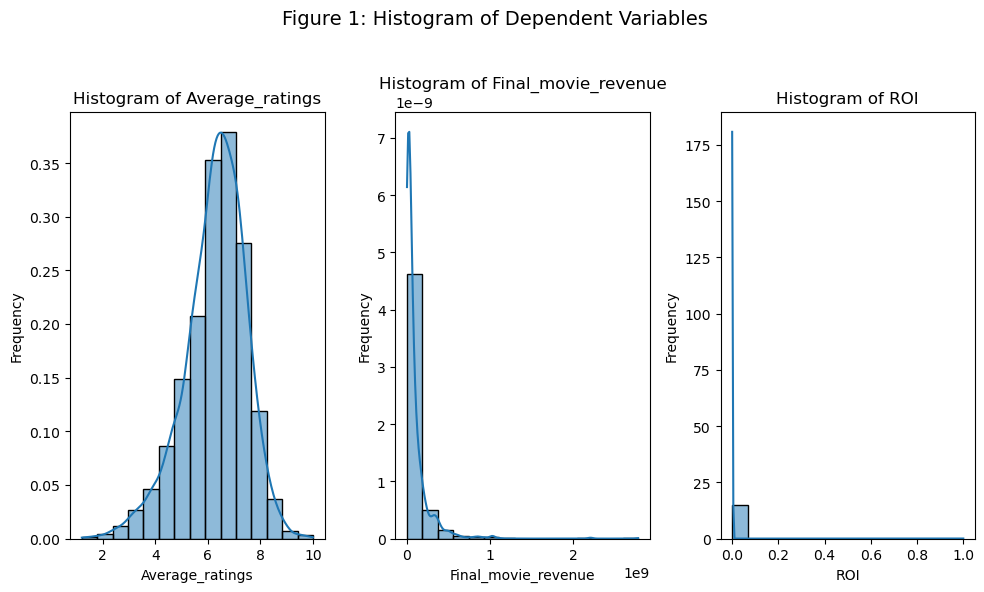

In [57]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 6))
fig.suptitle("Figure 1: Histogram of Dependent Variables", fontsize=14)
axes = axes.flatten()

dep_var = ["Average_ratings", "Final_movie_revenue", "ROI"]

# Plot histograms for each dependent variables
for i, col in enumerate(dep_var):
    if i < len(axes):  # Ensure we do not exceed the number of axes
        ax = axes[i]
        sns.histplot(final_df_copy, x=col, kde=True, stat="density", ax=ax, bins=15)
        ax.set_title(f"Histogram of {col}")
        ax.set_xlabel(col)
        ax.set_ylabel("Frequency")

# Hide any extra subplots if there are more axes than columns
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Make space for the title
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()

For P2, we will ignore the ROI metric and look at Average_ratings and Final_movie_revenue.

As we can see in Figure 1, the distribution of *Movie_box_office_revenue* is highly skewed. In order to adresse that, we have to apply a log transformation to it.

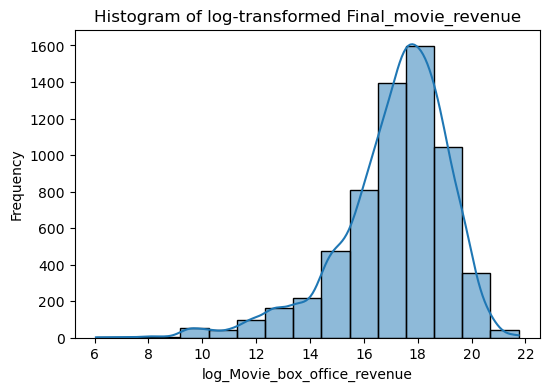

In [58]:
plt.figure(figsize=(6, 4))
sns.histplot(final_df_copy['Final_movie_revenue'].apply(math.log1p), kde=True, edgecolor="black", bins=15)
plt.title("Histogram of log-transformed Final_movie_revenue")
plt.xlabel("log_Movie_box_office_revenue")
plt.ylabel("Frequency")
plt.show()

Now we have successfully obtained a normal distribution for the *Movie_box_office_revenue*. Now, let's plot the independent variables. 

Let's now look at our independent variables.

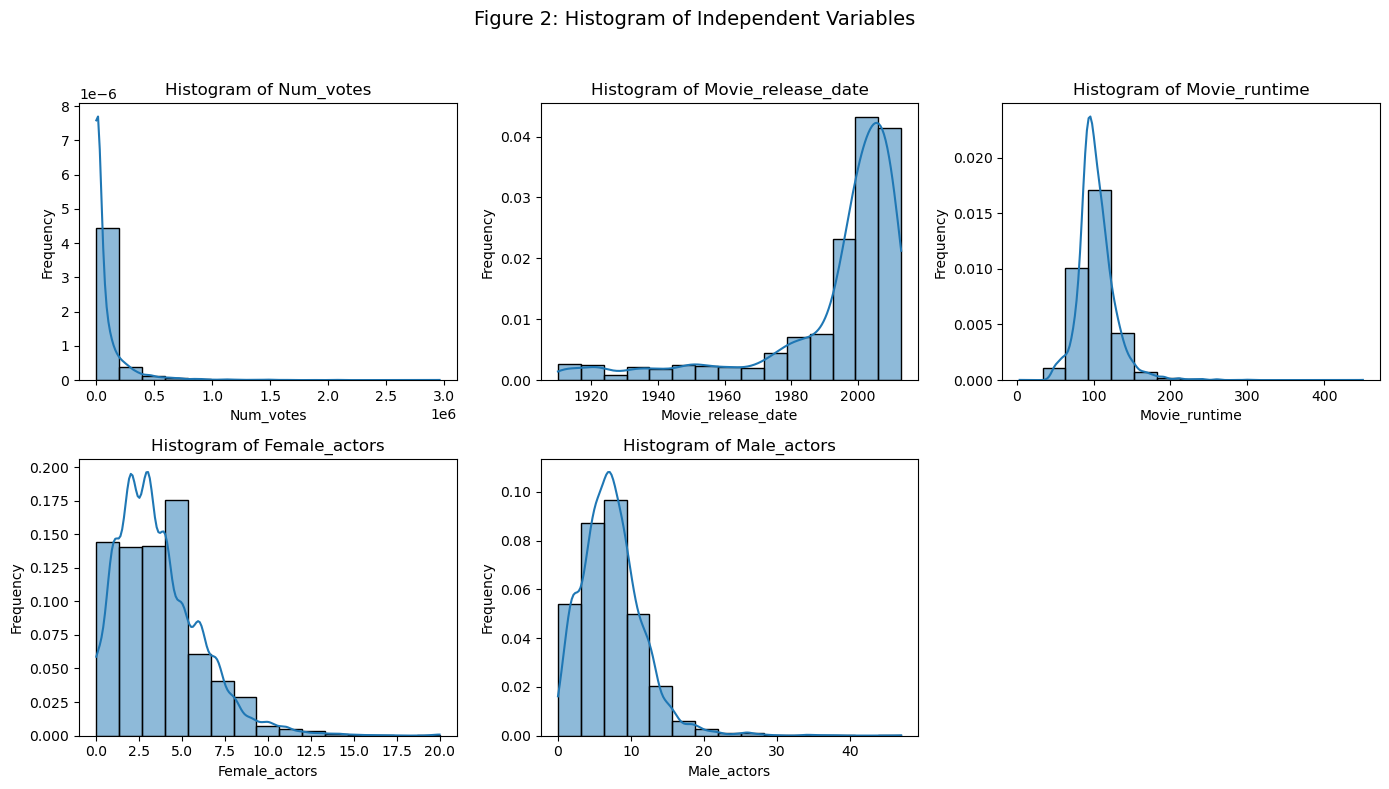

In [59]:
# Same as for the dependent variables
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 8))
fig.suptitle("Figure 2: Histogram of Independent Variables", fontsize=14)

axes = axes.flatten()

indep_var = ["Num_votes", "Movie_release_date", "Movie_runtime", "Female_actors", "Male_actors"]

# Plot histograms for each independent variable
for i, col in enumerate(indep_var):
    sns.histplot(final_df_copy, x=col, kde=True, stat="density", ax=axes[i], bins=15)
    axes[i].set_title(f"Histogram of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

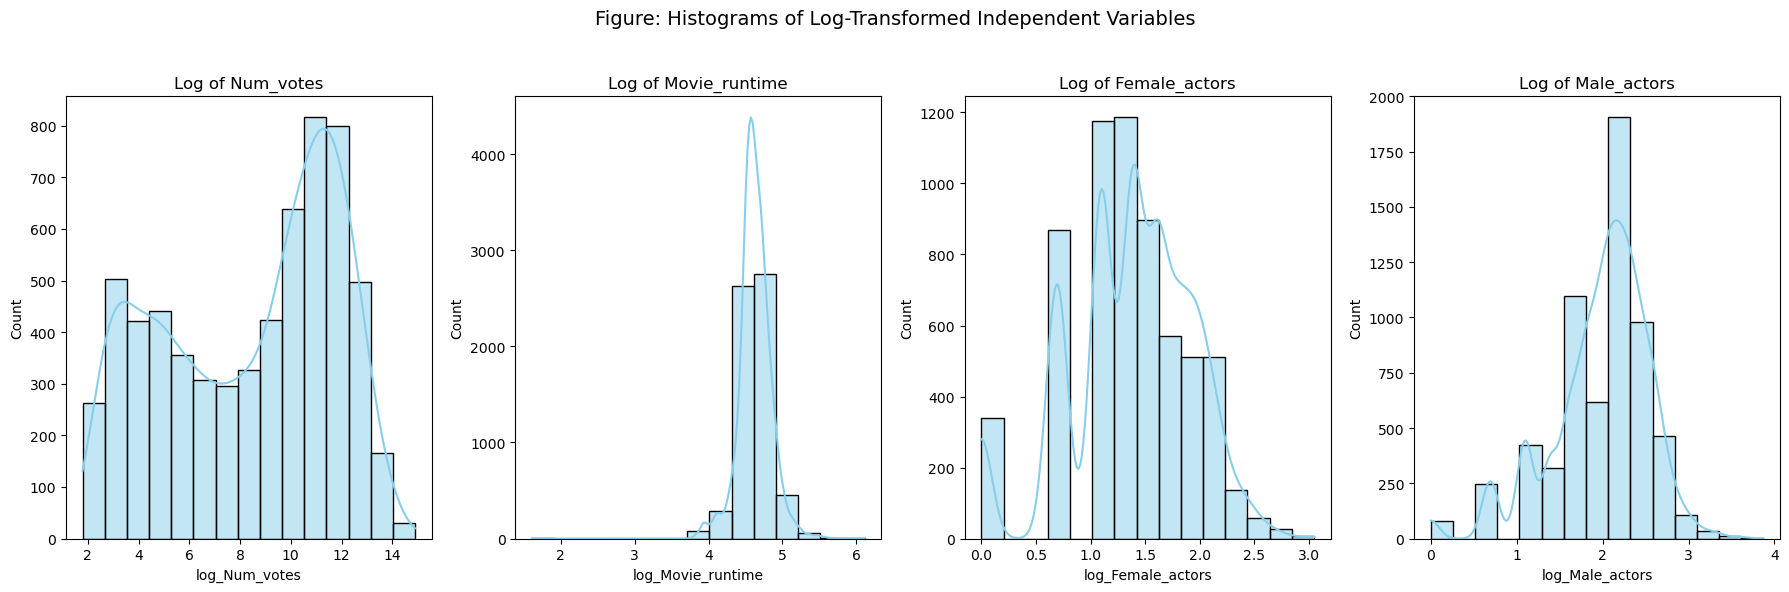

In [60]:
# Apply log transformation to skewed independent variables
final_df_copy['log_Num_votes'] = final_df_copy['Num_votes'].apply(math.log1p)
final_df_copy['log_Movie_runtime'] = final_df_copy['Movie_runtime'].apply(math.log1p)
final_df_copy['log_Female_actors'] = final_df_copy['Female_actors'].apply(math.log1p)
final_df_copy['log_Male_actors'] = final_df_copy['Male_actors'].apply(math.log1p)

# Plot histograms of the transformed variables
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 6))
fig.suptitle("Figure: Histograms of Log-Transformed Independent Variables", fontsize=14)

sns.histplot(final_df_copy['log_Num_votes'], kde=True, ax=axes[0], color="skyblue", bins=15)
axes[0].set_title("Log of Num_votes")

sns.histplot(final_df_copy['log_Movie_runtime'], kde=True, ax=axes[1], color="skyblue", bins=15)
axes[1].set_title("Log of Movie_runtime")

sns.histplot(final_df_copy['log_Female_actors'], kde=True, ax=axes[2], color="skyblue", bins=15)
axes[2].set_title("Log of Female_actors")

sns.histplot(final_df_copy['log_Male_actors'], kde=True, ax=axes[3], color="skyblue", bins=15)
axes[3].set_title("Log of Male_actors")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


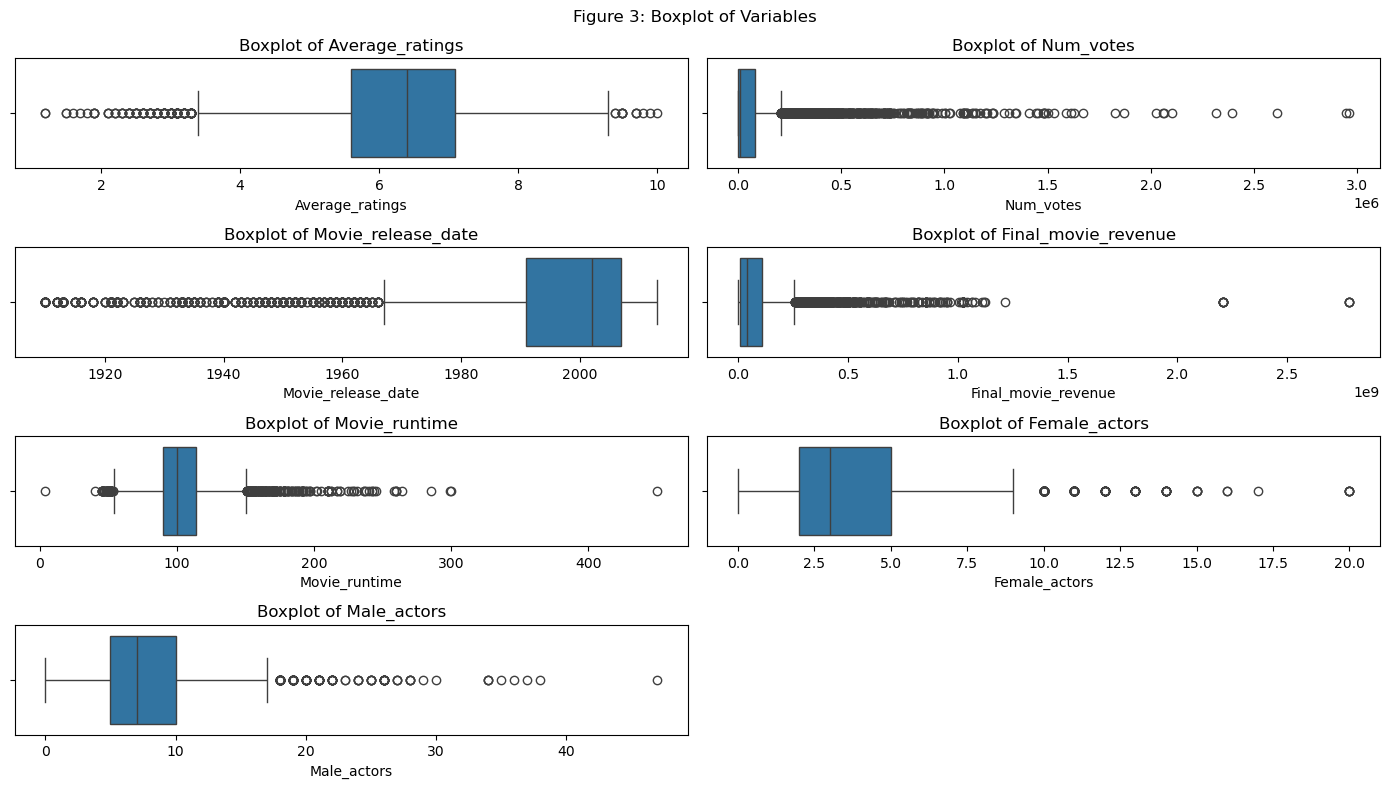

In [61]:
plt.figure(figsize=(14, 8))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(4, 2, i)
    sns.boxplot(data=final_df_copy, x=col)
    plt.title(f"Boxplot of {col}")
    
plt.suptitle("Figure 3: Boxplot of Variables")     
plt.tight_layout()
plt.show()

We now have to focus on outliers and removing them for a more accurate modeling. From the boxplots, we chose the remove the outliers of the *Movie_box_office_revenue* and the *Minutes_runtime* variables. To do that, we use the **InterQuartile Range (IQR) method**, which identifies values that are significantly higher or lower than the majority of the data.

The *remove_outliers* function will calculate the IQR for each column specified and removes any rows with values outside the range:

$[Q1 - 1.5 \times \text{IQR}, Q3 + 1.5 \times \text{IQR}]$


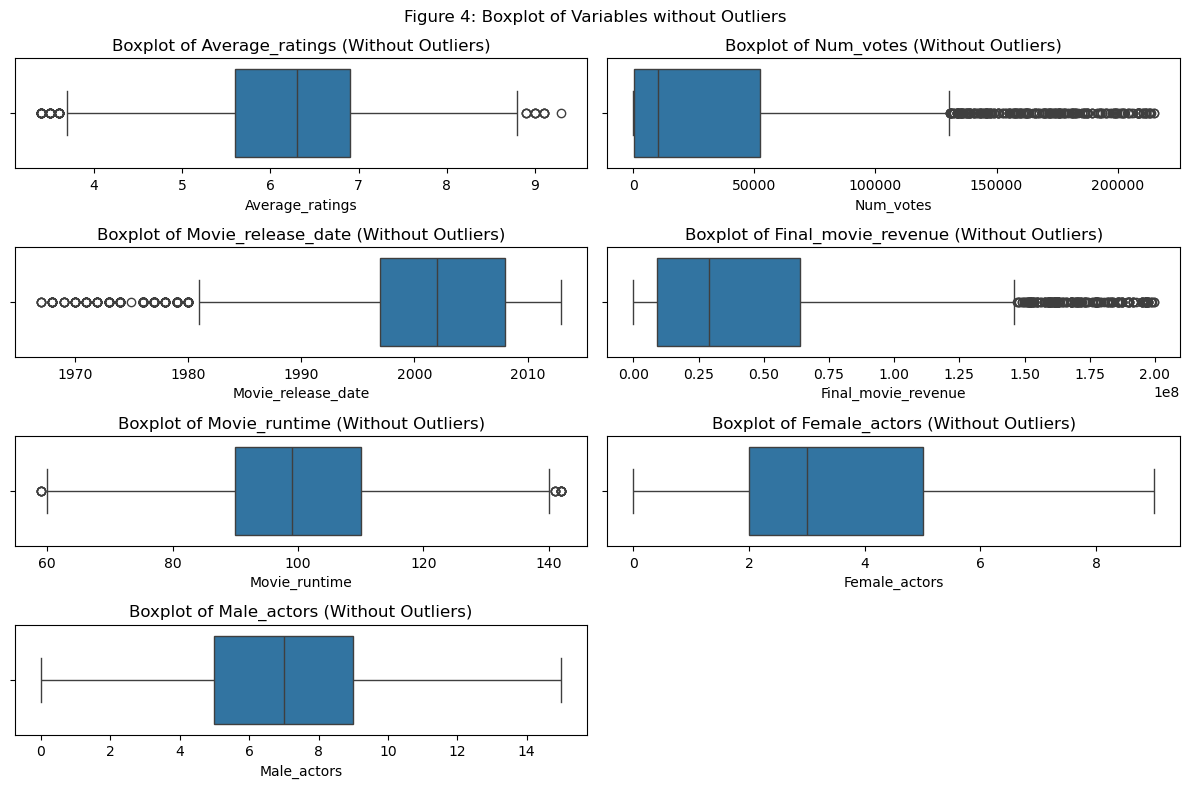

In [62]:
# Define a function to remove outliers based on IQR
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        # Define lower and upper bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Remove rows with values outside these bounds
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Create a copy of the dataframe without outliers
final_df_no_outliers = remove_outliers(final_df_copy, numeric_columns)

# Display the boxplot again to verify the outliers are removed
plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(4, 2, i)
    sns.boxplot(data=final_df_no_outliers, x=col)
    plt.title(f"Boxplot of {col} (Without Outliers)")
plt.suptitle("Figure 4: Boxplot of Variables without Outliers")
plt.tight_layout()
plt.show()

In [63]:
print(f"After removing the outliers and dropping the null values, we are left with {len(final_df_no_outliers):,} movies.")

After removing the outliers and dropping the null values, we are left with 4,013 movies.


##### 1.1.2 Bivariate Analysis of continuous variables
a. <u>Correlation matrix</u>:

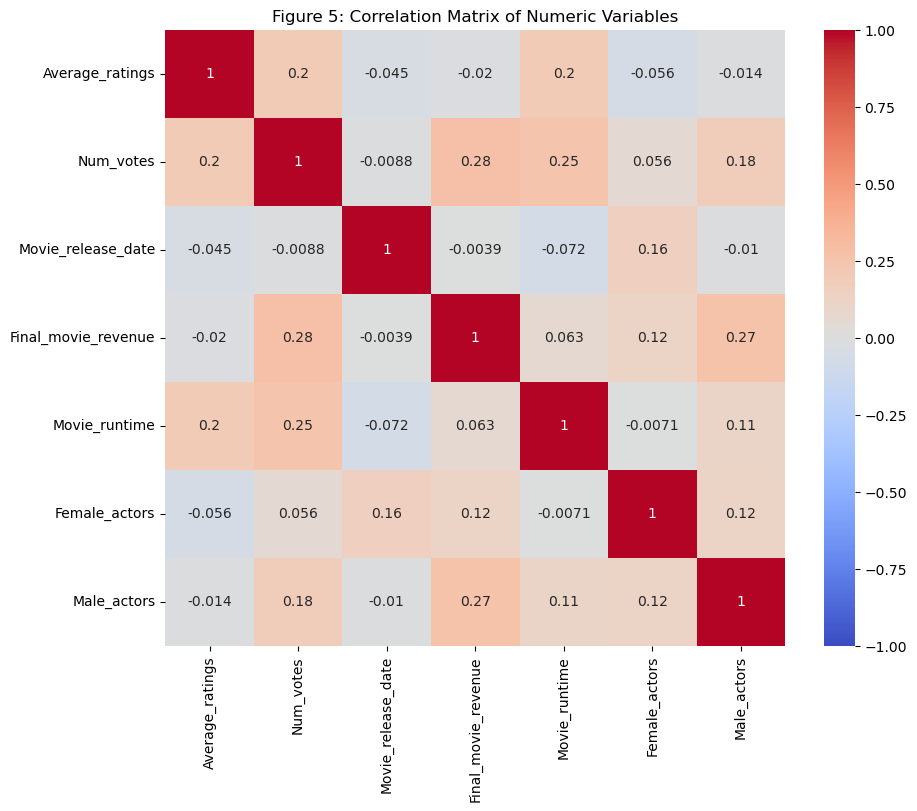

In [64]:
correlation_matrix = final_df_no_outliers[numeric_columns].corr()

# Calculate and visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Figure 5: Correlation Matrix of Numeric Variables")
plt.show()

The correlation matrix for the continuous variables in our dataset shows the following relationships:

•⁠  ⁠Female_actors and Male_actors : The correlation coefficient is *0.19*, indicating a weak positive correlation. This suggests that movies with a higher number of female actors also tend to have a higher number of male actors. We note that this could indicate a general tendency for larger casts to include more actors of both genders.

•⁠  ⁠Final_movie_revenue and Male_actors : The correlation coefficient is *0.26*, indicating a moderate positive correlation. This suggests that movies with more male actors might achieve higher box office earnings. 

•⁠  ⁠Final_movie_revenue and Female_actors : The correlation coefficient is *0.16*, indicating a weak positive correlation. This suggests that movies with more female actors also have a slight tendency to generate higher revenue. We note however that this relationship is weaker than with male actors. 

•⁠  ⁠Female_actors and Movie_release_date : The correlation coefficient is *0.15*, indicating a weak positive correlation. This suggests that more recent movies tend to include a higher number of female actors. 

While gender composition affects the correlation, these findings highlight the need for deeper analysis (e.g., regression) to control for potential confounders and isolate the impact of gender on box office success.

b. <u>Scatter plots </u>:

/opt/anaconda3/envs/ada/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


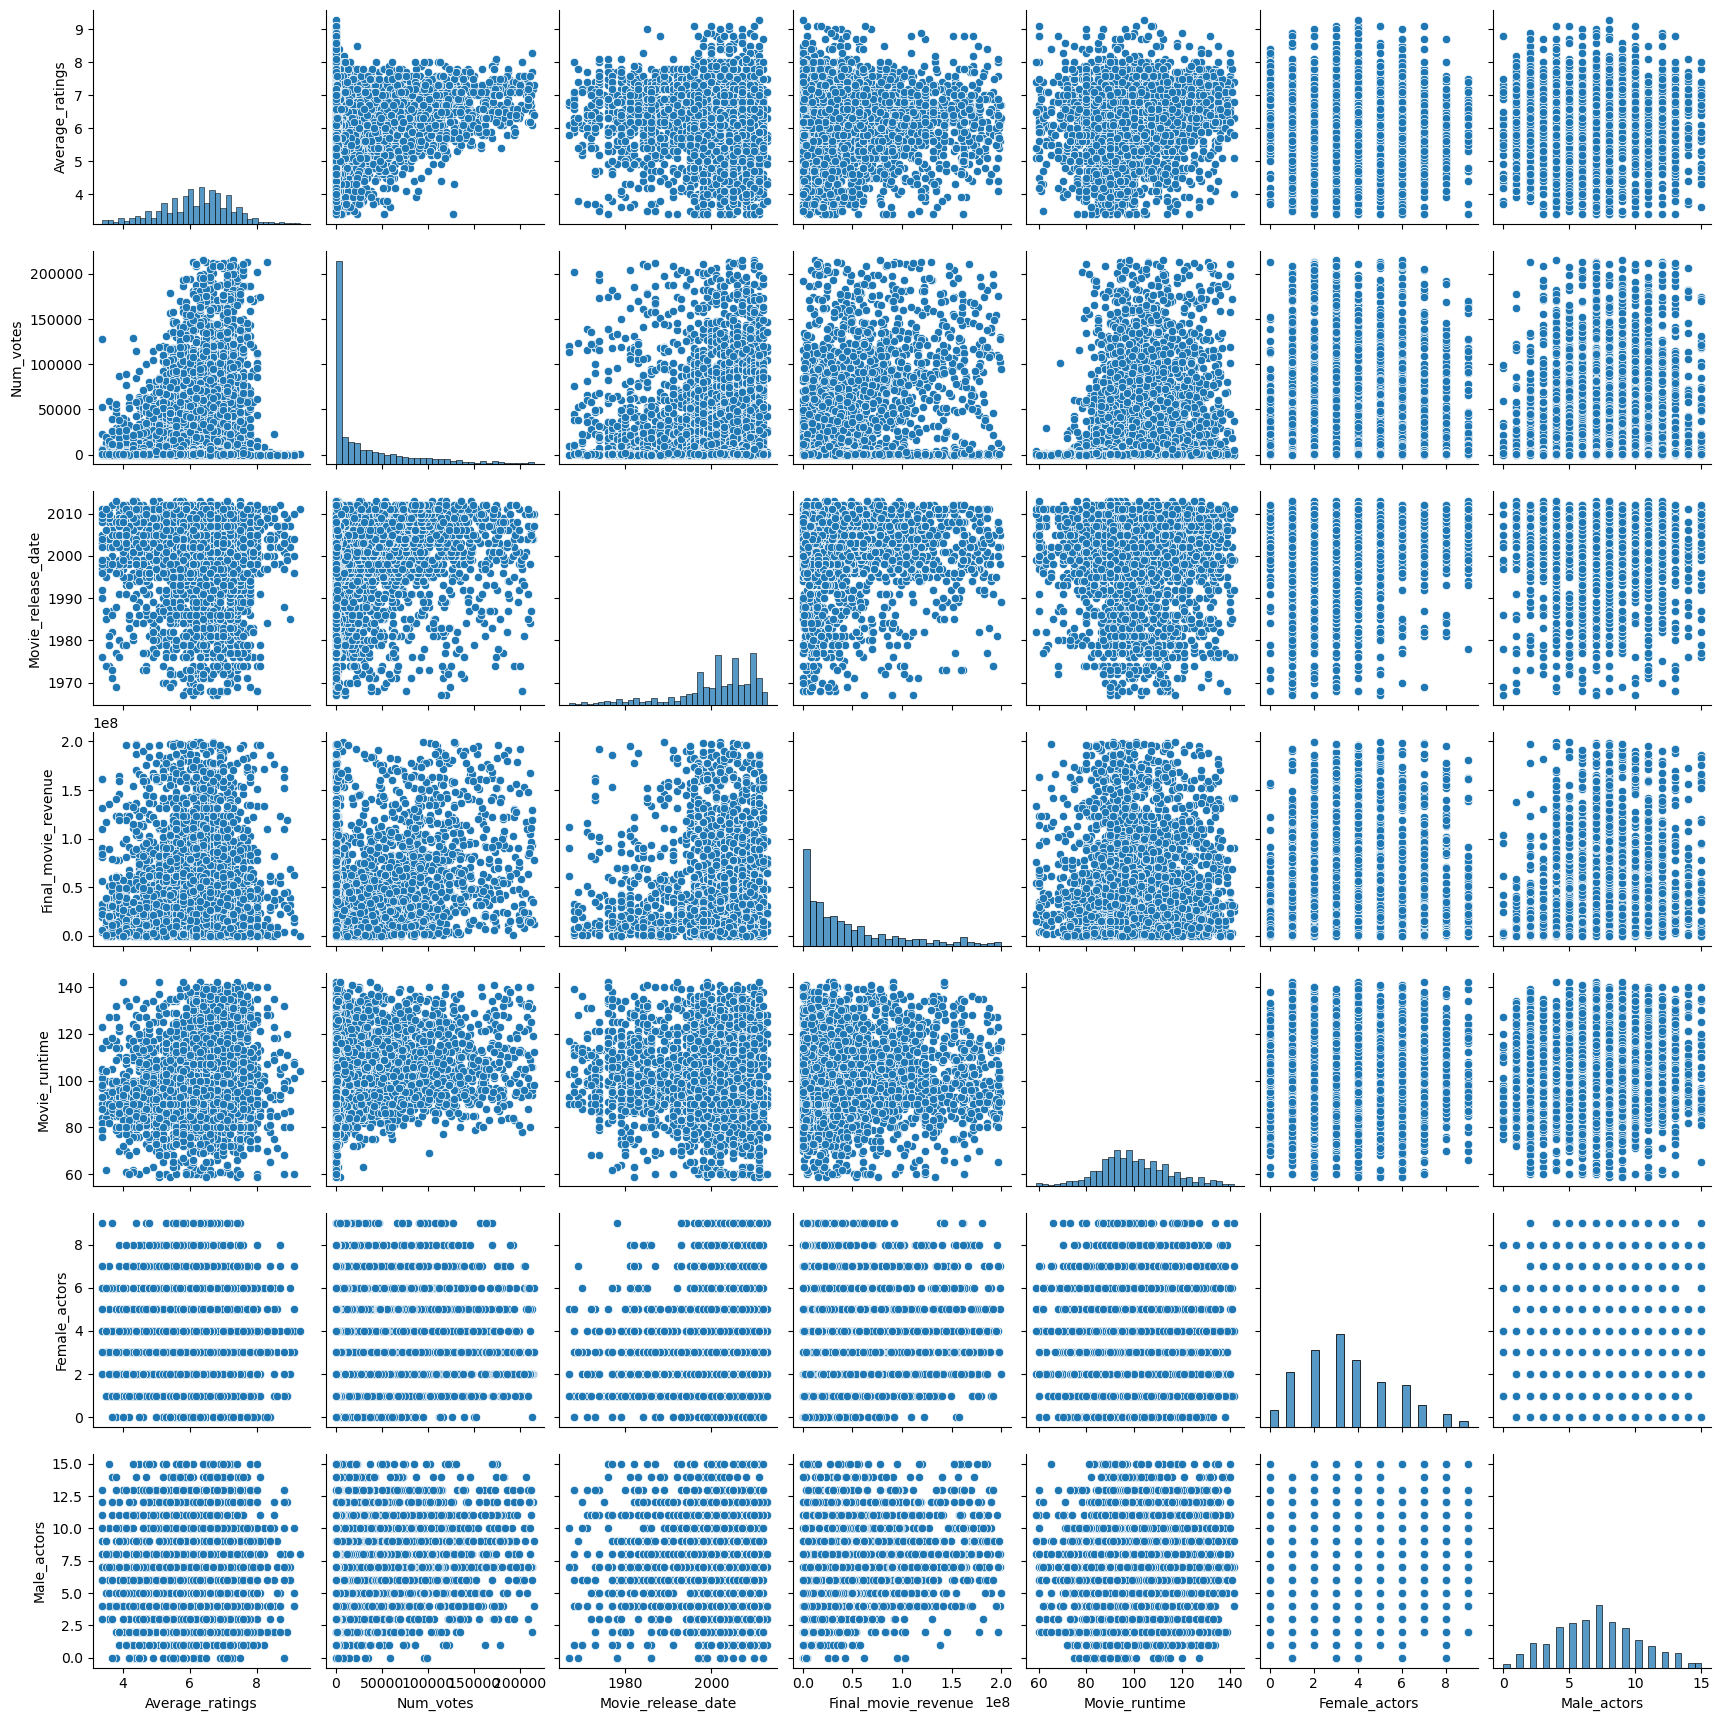

In [65]:
sns.pairplot(final_df_no_outliers[numeric_columns])

#### The categorical variables
Regression analysis with many categorical variables can quickly get complicated. Indeed using a boolean value for each category except one can cause us to have too many regressors. For variables like isAdult and Gender it is easy as there are only two possibilities. However, for Movie_genre, Movie_countries and Movie_languages we can quickly get into the hundreds. Here is how we plan on managing this:

#### Movie_genre

We set a cutoff threshold of 400. This means all genres with less than 400 occurences will be discarded. 

In [66]:
N = 400  # Threshold for filtering genres

genres_series = (
    final_df_copy["Movie_genres"]
    .str.replace(r"[\[\]']", "", regex=True)  # Clean the string further for this application
    .str.split(', ')  # Split the genre strings into lists for easier manipulation, using ', ' as the delimiter
    .explode()  # Expand the lists into separate rows with one genre per row
    .str.strip()  # Strip leading and trailing whitespace from each genre
    .str.lower()
)

# Get the count of each genre
genre_counts = genres_series.value_counts()

# Filter out genres with counts < N
filtered_genre_counts = genre_counts[genre_counts >= N]  

# Count the number of genres appearing at least N times
len(filtered_genre_counts) 

20

Let us check if this restricts our study to too few movies.

In [67]:
# List of genres that meet the threshold
popular_genres = filtered_genre_counts.index.tolist()

# Remove all special characters from the strings to allow proper regex matching
no_special_char = map(re.escape, popular_genres)

# Create regex pattern using the "OR" operator
pattern = '|'.join(no_special_char) 

# Check thanks to the regex pattern if any of the popular genres are in each column of th edataframe
rows_with_popular_genres = final_df_copy["Movie_genres"].str.contains(pattern, case=False, na=False)

print(f"There are {rows_with_popular_genres.sum()} movies that belong to at least one of the {len(filtered_genre_counts)} most popular genres.",
      f"\nThere were {len(final_df_copy)} movies in the dataset before this operation.")

There are 6196 movies that belong to at least one of the 20 most popular genres. 
There were 6282 movies in the dataset before this operation.


This threshold operation barely reduces the number of datapoints in the dataset as movies usually have multiple genres associated to them meaning there is a high chance that one of the 20 most popular genres figures amongst them.

We are left with 20 genres. We can sort them manually into 5 big categories:
- Drama & Emotion
- Action & Adventure
- Science Fiction & Fantasy
- Comedy & Light-Hearted
- Thriller and Horror

In [68]:
# Exporting as csv to manually sort before re-importing.
filtered_genre_counts_df = filtered_genre_counts.reset_index()
filtered_genre_counts_df.columns = ["Genre", "Count"]

filtered_genre_counts_df.to_csv("filtered_genre_counts.csv", index=False)

The resulting manual classification can be found in ``Genre_Classification_with_Categories.csv``

The next step is to create a new column called ``Genre_Category`` and assign the right values.

In [69]:
classification_df = pd.read_csv("Genre_Classification_with_Categories.csv")

# Create a dictionary mapping genres to categories
genre_to_category = dict(zip(classification_df["Genre"], classification_df["Category"]))

def map_categories(row):
    # Ensure proper string formatting (remove whitespaces, make everything lowercas and split according to ",")
    genres = [genre.strip().lower() for genre in row.split(",")]
    
    # Map genres to categories. get() allows us to return None if no category was found
    categories = [genre_to_category.get(genre, None) for genre in genres]
    
    # If there are non None values we want to only keep those, if there are only None values we want to get None
    categories = [category for category in categories if category is not None]
    
    # If no categories match, return None, if not return the categories seperated by ",". Remove duplicates using set().
    if categories:
        return ", ".join(set(categories))
    else:
        return None

# Normalize genres in the dictionary
genre_to_category = {key.strip().lower(): value for key, value in genre_to_category.items()}

# Classify the genres into their respective categories
final_df_copy["Movie_categories"] = final_df_copy["Movie_genres"].apply(map_categories)

# Filtering out the rows that have not been assigned to one of the five genre categories
final_df_copy = final_df_copy[final_df_copy["Movie_categories"].notnull()]

In [70]:
final_df_copy.head()

,Average_ratings,Num_votes,Primary_title,Original_title,Is_adult,Start_year,Directors,Writers,Movie_release_date,Movie_languages,...,Movie_budget,Final_movie_revenue,ROI,Normalized_Rating,movie_success,log_Num_votes,log_Movie_runtime,log_Female_actors,log_Male_actors,Movie_categories
4,4.70,40,"hamlet, prince of denmark",hamlet,0,1910,nm0099901,nm0000636,1921,german language,...,"18,000,000.00","7,129,670.00",0.00,0.47,0.16,3.71,4.72,1.10,1.79,Drama and Emotion
5,4.70,40,"hamlet, prince of denmark",hamlet,0,1910,nm0099901,nm0000636,1921,german language,...,"2,000,000.00","2,419,669.00",0.00,0.47,0.16,3.71,4.72,1.10,1.79,Drama and Emotion
7,3.80,22,hamlet,hamlet,0,1911,nm0088881,nm0000636,1921,german language,...,"18,000,000.00","7,129,670.00",0.00,0.38,0.13,3.14,4.72,1.10,1.79,Drama and Emotion
8,3.80,22,hamlet,hamlet,0,1911,nm0088881,nm0000636,1921,german language,...,"2,000,000.00","2,419,669.00",0.00,0.38,0.13,3.14,4.72,1.10,1.79,Drama and Emotion
9,5.10,634,cleopatra,cleopatra,0,1912,nm0309130,"nm0765026,nm0309130",1912,english language,...,"42,000,000.00","71,000,000.00",0.00,0.51,0.17,6.45,4.62,1.39,1.10,Drama and Emotion


In [71]:
final_df_copy["Movie_categories"].value_counts()
print(len(final_df_copy))

6187


In [72]:
nlp_df = final_df_copy.dropna(subset=["Plot Summaries", "Movie_categories"])
print(len(nlp_df))

5440


In [73]:
nlp_df["word_count"] = nlp_df["Plot Summaries"].apply(lambda x: len(str(x).split()))

print(nlp_df[["Plot Summaries", "word_count"]].sort_values(by="word_count", ascending=False).iloc[0])
nlp_df.drop(columns=["word_count"], inplace=True)

Plot Summaries    The film begins with a voice-over monologue by...
word_count                                                     3138
Name: 21266, dtype: object


/var/folders/7f/nwg71rx96nbb88bp63jq_ndr0000gn/T/ipykernel_14998/2844584974.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nlp_df["word_count"] = nlp_df["Plot Summaries"].apply(lambda x: len(str(x).split()))
/var/folders/7f/nwg71rx96nbb88bp63jq_ndr0000gn/T/ipykernel_14998/2844584974.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nlp_df.drop(columns=["word_count"], inplace=True)


In [74]:
#Clean Movie_categories 
nlp_df["Movie_categories"] = nlp_df["Movie_categories"].str.strip()
nlp_df["Movie_categories"] = nlp_df["Movie_categories"].apply(lambda x: x.split(",") if "," in x else [x])
nlp_df["Movie_categories"] = nlp_df["Movie_categories"].apply(lambda x: [genre.strip() for genre in x])

#Clean Plot Summaries
nlp_df["Plot Summaries"] = nlp_df["Plot Summaries"].str.strip()

print(nlp_df[["Plot Summaries", "Movie_categories"]].head())

                                       Plot Summaries  \
19  In 1815, a French merchant ship stops at the i...   
30  The opening has the dashing Earl of Huntingdon...   
31  The opening has the dashing Earl of Huntingdon...   
49  Cinderella is the much-loved only child of a w...   
50  Cinderella is the much-loved only child of a w...   

                                     Movie_categories  
19  [Drama and Emotion, Action and Adventure, Thri...  
30  [Comedy and Light-Hearted, Drama and Emotion, ...  
31  [Comedy and Light-Hearted, Drama and Emotion, ...  
49  [Science Fiction and Fantasy, Drama and Emotio...  
50  [Science Fiction and Fantasy, Drama and Emotio...  


/var/folders/7f/nwg71rx96nbb88bp63jq_ndr0000gn/T/ipykernel_14998/4237210431.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nlp_df["Movie_categories"] = nlp_df["Movie_categories"].str.strip()
/var/folders/7f/nwg71rx96nbb88bp63jq_ndr0000gn/T/ipykernel_14998/4237210431.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nlp_df["Movie_categories"] = nlp_df["Movie_categories"].apply(lambda x: x.split(",") if "," in x else [x])
/var/folders/7f/nwg71rx96nbb88bp63jq_ndr0000gn/T/ipykernel_14998/4237210431.py:4:

In [75]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, accuracy_score, hamming_loss, jaccard_score


tfidf_vect = TfidfVectorizer(max_features=3500, stop_words="english")  #3500>the max number of festures for a description
X = tfidf_vect.fit_transform(nlp_df["Plot Summaries"])


multilbl = MultiLabelBinarizer()
y = multilbl.fit_transform(nlp_df["Movie_categories"])

print("Movies unique categories :", multilbl.classes_)
print("Binary labels :\n", y[:10])



Movies unique categories : ['Action and Adventure' 'Comedy and Light-Hearted' 'Drama and Emotion'
 'Science Fiction and Fantasy' 'Thriller and Horror']
Binary labels :
 [[1 0 1 0 1]
 [1 1 1 0 0]
 [1 1 1 0 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [1 0 0 0 0]
 [0 0 1 0 1]
 [1 0 0 0 1]
 [0 1 1 0 0]
 [0 0 1 0 0]]


In [76]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training size :", X_train.shape)
print("Testing size :", X_test.shape)

Training size : (4352, 3500)
Testing size : (1088, 3500)


In [77]:
model = OneVsRestClassifier(RandomForestClassifier(n_estimators=2000, random_state=42))
model.fit(X_train, y_train)

OneVsRestClassifier(estimator=RandomForestClassifier(n_estimators=2000,
                                                     random_state=42))

In [78]:

y_proba_full = model.predict_proba(X)

print(y_proba_full[:10])

[[9.995e-01 5.000e-04 9.995e-01 0.000e+00 9.990e-01]
 [1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00]
 [1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00]
 [0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [5.150e-02 6.300e-02 9.480e-01 5.200e-02 9.175e-01]
 [1.000e+00 5.000e-04 5.000e-04 5.000e-04 9.990e-01]
 [3.000e-02 9.320e-01 9.630e-01 4.100e-02 3.050e-02]
 [2.500e-03 1.100e-02 9.990e-01 2.500e-03 1.000e-03]]


In [79]:
is_binary_line = np.all((y_proba_full == 0) | (y_proba_full == 1), axis=1)
binary_line_count = np.sum(is_binary_line)
print(f"Number of lines with only 0 and 1 : {binary_line_count}")

Number of lines with only 0 and 1 : 576


In [80]:
y_pred = model.predict(X_test)
predicted_genres = multilbl.inverse_transform(y_pred)

print(predicted_genres[:5])

[('Action and Adventure', 'Drama and Emotion'), ('Comedy and Light-Hearted', 'Drama and Emotion', 'Science Fiction and Fantasy'), ('Comedy and Light-Hearted', 'Drama and Emotion', 'Thriller and Horror'), ('Drama and Emotion',), ('Action and Adventure',)]


In [81]:

print(classification_report(y_test, y_pred, target_names=multilbl.classes_))

                             precision    recall  f1-score   support

       Action and Adventure       0.91      0.91      0.91       505
   Comedy and Light-Hearted       0.91      0.89      0.90       507
          Drama and Emotion       0.88      0.95      0.91       667
Science Fiction and Fantasy       0.96      0.74      0.83       346
        Thriller and Horror       0.95      0.91      0.93       485

                  micro avg       0.91      0.89      0.90      2510
                  macro avg       0.92      0.88      0.90      2510
               weighted avg       0.92      0.89      0.90      2510
                samples avg       0.91      0.91      0.90      2510



/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [82]:
hamming = hamming_loss(y_test, y_pred)
print(f"Hamming Loss : {hamming:.4f}")


Hamming Loss : 0.0888


In [83]:
jaccard = jaccard_score(y_test, y_pred, average='samples')
print(f"Jaccard Similarity : {jaccard:.4f}")


Jaccard Similarity : 0.8566


In [84]:

import random

most_relevant_genres = []

for i, probs in enumerate(y_proba_full):
    if np.all((probs == 0) | (probs == 1)):
        indices_of_ones = np.where(probs == 1)[0]
        selected_index = random.choice(indices_of_ones)
    else:
        max_value = probs.max()
        indices_of_max = np.where(probs == max_value)[0]
        selected_index = random.choice(indices_of_max)
    

    most_relevant_genres.append(multilbl.classes_[selected_index])



In [85]:

nlp_df['Movie_categories'] = most_relevant_genres
nlp_df["Movie_categories"].value_counts()

/var/folders/7f/nwg71rx96nbb88bp63jq_ndr0000gn/T/ipykernel_14998/428434476.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nlp_df['Movie_categories'] = most_relevant_genres


Movie_categories
Drama and Emotion              2244
Action and Adventure           1256
Thriller and Horror             850
Comedy and Light-Hearted        834
Science Fiction and Fantasy     256
Name: count, dtype: int64

We will now create the dummy variables using one-hot encoding. This needs to be done carefully as some rows have multiple categories assigned to them. This may raise multicollinearity issues in the model.

In [86]:
category_list = set(classification_df["Category"])

for category in category_list:
    category_name = category.lower().replace(" ","_")
    final_df_copy[f"Category_{category_name}"] = final_df_copy["Movie_categories"].apply(
        lambda x: 1 if category in x else 0
    )

#### Movie_languages

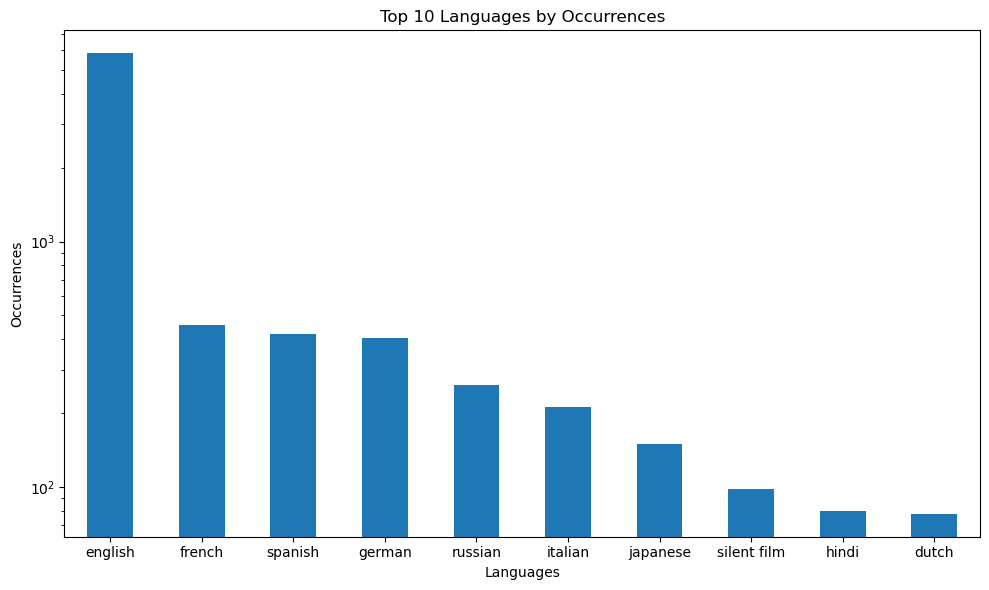

In [87]:
language_series = (
    final_df_copy['Movie_languages']
    .str.replace(r"[\[\]']", "", regex=True) 
    .str.split(', ')
    .explode()
    .str.strip()
    .str.lower()
    .str.replace(" language", "")
)


language_count = language_series.value_counts()
language_count.head(10).plot(kind='bar', figsize=(10, 6))
plt.xlabel('Languages')
plt.ylabel('Occurrences')
plt.title('Top 10 Languages by Occurrences')
plt.xticks(rotation=0)
plt.yscale('log')
plt.tight_layout()
plt.show()

For Movie_languages we decided to take the 4 most common languages. This allows us to analyze the impact of language. However, we will still have an unbalanced dataset with English being much more prominent than other languages.

We will conduct a first analysis using only English, then we will conduct a second analysis with the top 4 languages after rebalancing the dataset.

In [88]:
top_languages = language_count[:4].index.tolist()

# Dropping all the rows that do not have one of the top 4 languages.
final_df_copy = final_df_copy[final_df_copy['Movie_languages'].str.contains('|'.join(top_languages), case=False, na=False)]

print(f"We are left with {len(final_df_copy)} datapoints.")

We are left with 5998 datapoints.


We again have certain rows with multiple languages. We must proceed in a similar way to the genres above to obtain the dummy variables.

In [89]:
for language in top_languages:
    # Create the dummies
    final_df_copy[f"Category_{language}_language"] = final_df_copy["Movie_languages"].apply(lambda x: 1 if language in x else 0)
    
    print(f"There are {len(final_df_copy[final_df_copy[f'Category_{language}_language'] == 1])} {language} movies")

There are 5843 english movies
There are 457 french movies
There are 422 spanish movies
There are 403 german movies


We can see how unbalanced the dataset is, with 5840 english movies against around 400 movies for the other languages.

#### 1.2 Identifying Potential Confounders
In order to not have bias in our study, it is essential we add the confounders. This means that we have to identify the variables that have an impact on both treatment and outcome, here being the actor gender and the final box office revenue respectivly. The confounders are: 
-  ⁠Movie_genre
-  ⁠Movie_countries
- ⁠Movie_languages

### 4. <u>How does it compare to streaming platforms? Are movies made for these platforms different?</u>

In this section, we want to expand our study by analyzing data from various streaming platforms. We focus on the movies of Netflix, Amazon Prime, Disney+, and Hulu. To achieve this, we created a dataset by merging data from multiple sources found on Kaggle.


This dataset structure enables comprehensive analysis across various dimensions such as gender repartition in the cast, the ratings and description. Using these columns, we can investigate how streaming platform movies differ in content and ratings compared to traditional box office movies.



In [90]:
from src.scripts.streaming import get_streaming_dataframe

streaming_df = get_streaming_dataframe()

/Users/yoancodjia/Desktop/env_python/P2/ada-2024-project-kungfupandas24/src/scripts/streaming.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_movies_cleaned["cast"] = all_movies_cleaned["cast"].str.split(", ")
/Users/yoancodjia/Desktop/env_python/P2/ada-2024-project-kungfupandas24/src/scripts/streaming.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_movies_cleaned["cast"] = all_movies_cleaned["cast"].apply(lambda x: ", ".join(x))
/Users/yoancodjia/Desktop/env_python/P2/ada-2024-project-kun

In [91]:
streaming_df.head()

,Show_id,Type,Movie_name,Director,Cast,Movie_countries,Date_added,Movie_release_date,Age_ratings,Movie_runtime,Movie_genres,Description,Platform,Male_actors,Female_actors,Average_Rating,Num_Votes,Is_Adult,Movie_languages
1,s8,Movie,Sankofa,Haile Gerima,"Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...","United States, Ghana, Burkina Faso, United Kin...","September 24, 2021",1993,TV-MA,125.00,"Dramas, Independent Movies","On a photo shoot in Ghana, an American model s...",Netflix,2,2,7.00,859,1,"French, English, German"
2,s10,Movie,The Starling,Theodore Melfi,"Melissa McCarthy, Chris O'Dowd, Kevin Kline, T...",United States,"September 24, 2021",2021,PG-13,104.00,"Comedies, Dramas",A woman adjusting to life after a loss contend...,Netflix,5,6,6.40,15653,0,English
3,s13,Movie,Je Suis Karl,Christian Schwochow,"Luna Wedler, Jannis Niewöhner, Milan Peschel, ...","Germany, Czech Republic","September 23, 2021",2021,TV-MA,127.00,Dramas,After most of her family is murdered in a terr...,Netflix,3,6,5.60,1622,1,"Czech, German"
8,s25,Movie,Jeans,S. Shankar,"Prashanth, Aishwarya Rai Bachchan, Sri Lakshmi...",India,"September 21, 2021",1998,TV-14,166.00,"Comedies, Romantic Movies",When the father of the man she loves insists t...,Netflix,0,1,6.50,4085,0,Hindi
9,s28,Movie,Grown Ups,Dennis Dugan,"Adam Sandler, Kevin James, Chris Rock, David S...",United States,"September 20, 2021",2010,PG-13,103.00,Comedies,Mourning the loss of their beloved junior high...,Netflix,5,6,6.00,286335,0,English


In [92]:
streaming_df["Movie_genres"] = streaming_df["Movie_genres"].str.replace("Documentaries", "", regex=False)
streaming_df["Movie_genres"] = streaming_df["Movie_genres"].str.replace("International Movies", "", regex=False)
# Nettoyer les séparateurs inutiles comme ", " qui pourraient rester
streaming_df["Movie_genres"] = streaming_df["Movie_genres"].str.replace(", ,", ",", regex=False)  # Double virgule
streaming_df["Movie_genres"] = streaming_df["Movie_genres"].str.strip(", ")  # Virgule au début ou à la fin

streaming_df.head()

,Show_id,Type,Movie_name,Director,Cast,Movie_countries,Date_added,Movie_release_date,Age_ratings,Movie_runtime,Movie_genres,Description,Platform,Male_actors,Female_actors,Average_Rating,Num_Votes,Is_Adult,Movie_languages
1,s8,Movie,Sankofa,Haile Gerima,"Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...","United States, Ghana, Burkina Faso, United Kin...","September 24, 2021",1993,TV-MA,125.00,"Dramas, Independent Movies","On a photo shoot in Ghana, an American model s...",Netflix,2,2,7.00,859,1,"French, English, German"
2,s10,Movie,The Starling,Theodore Melfi,"Melissa McCarthy, Chris O'Dowd, Kevin Kline, T...",United States,"September 24, 2021",2021,PG-13,104.00,"Comedies, Dramas",A woman adjusting to life after a loss contend...,Netflix,5,6,6.40,15653,0,English
3,s13,Movie,Je Suis Karl,Christian Schwochow,"Luna Wedler, Jannis Niewöhner, Milan Peschel, ...","Germany, Czech Republic","September 23, 2021",2021,TV-MA,127.00,Dramas,After most of her family is murdered in a terr...,Netflix,3,6,5.60,1622,1,"Czech, German"
8,s25,Movie,Jeans,S. Shankar,"Prashanth, Aishwarya Rai Bachchan, Sri Lakshmi...",India,"September 21, 2021",1998,TV-14,166.00,"Comedies, Romantic Movies",When the father of the man she loves insists t...,Netflix,0,1,6.50,4085,0,Hindi
9,s28,Movie,Grown Ups,Dennis Dugan,"Adam Sandler, Kevin James, Chris Rock, David S...",United States,"September 20, 2021",2010,PG-13,103.00,Comedies,Mourning the loss of their beloved junior high...,Netflix,5,6,6.00,286335,0,English


In [93]:
N = 200  # Threshold for filtering genres
streaming_df_copy=streaming_df.copy()
genres_series_bis = (
    streaming_df_copy["Movie_genres"]
    .str.replace(r"[\[\]']", "", regex=True)  # Clean the string further for this application
    .str.split(', ')  # Split the genre strings into lists for easier manipulation, using ', ' as the delimiter
    .explode()  # Expand the lists into separate rows with one genre per row
    .str.strip()  # Strip leading and trailing whitespace from each genre
    .str.lower()
)


# Get the count of each genre
genre_counts = genres_series_bis.value_counts()

# Filter out genres with counts < N
filtered_genre_counts = genre_counts[genre_counts >= N]  

# Count the number of genres appearing at least N times
len(filtered_genre_counts) 
print(filtered_genre_counts.index.tolist())


['dramas', 'comedies', 'action & adventure', 'independent movies', 'thrillers', 'romantic movies', 'comedy', 'family', 'children & family movies', 'drama', 'horror movies', 'action-adventure', 'sci-fi & fantasy', 'animation', 'music & musicals', 'stand-up comedy']


In [94]:
print("Nombre d'occurrences pour chaque catégorie (après filtrage) :")
for genre, count in filtered_genre_counts.items():
    print(f"{genre}: {count}")

Nombre d'occurrences pour chaque catégorie (après filtrage) :
dramas: 2216
comedies: 1485
action & adventure: 888
independent movies: 705
thrillers: 618
romantic movies: 571
comedy: 486
family: 458
children & family movies: 444
drama: 394
horror movies: 367
action-adventure: 360
sci-fi & fantasy: 311
animation: 302
music & musicals: 261
stand-up comedy: 248


In [95]:
N = 200  # Threshold for filtering genres

genres_series_bis = (
    streaming_df["Movie_genres"]
    .str.replace(r"[\[\]']", "", regex=True)  # Clean the string further for this application
    .str.split(', ')  # Split the genre strings into lists for easier manipulation, using ', ' as the delimiter
    .explode()  # Expand the lists into separate rows with one genre per row
    .str.strip()  # Strip leading and trailing whitespace from each genre
    .str.lower()
)


# Get the count of each genre
genre_counts = genres_series_bis.value_counts()

# Filter out genres with counts < N
filtered_genre_counts = genre_counts[genre_counts >= N]  

# Count the number of genres appearing at least N times
len(filtered_genre_counts) 
print(filtered_genre_counts.index.tolist())


['dramas', 'comedies', 'action & adventure', 'independent movies', 'thrillers', 'romantic movies', 'comedy', 'family', 'children & family movies', 'drama', 'horror movies', 'action-adventure', 'sci-fi & fantasy', 'animation', 'music & musicals', 'stand-up comedy']


In [96]:
# List of genres that meet the threshold
popular_genres = filtered_genre_counts.index.tolist()

# Remove all special characters from the strings to allow proper regex matching
no_special_char = map(re.escape, popular_genres)

# Create regex pattern using the "OR" operator
pattern = '|'.join(no_special_char) 

# Check thanks to the regex pattern if any of the popular genres are in each column of th edataframe
rows_with_popular_genres = final_df_copy["Movie_genres"].str.contains(pattern, case=False, na=False)

print(f"There are {rows_with_popular_genres.sum()} movies that belong to at least one of the {len(filtered_genre_counts)} most popular genres.",
      f"\nThere were {len(final_df_copy)} movies in the dataset before this operation.")

There are 4931 movies that belong to at least one of the 16 most popular genres. 
There were 5998 movies in the dataset before this operation.


In [97]:
streaming_df.drop_duplicates(inplace=True)

a. <u>Numerical Analysis</u>: 

In [98]:
numeric_columns_streaming = ["Average_Rating", "Num_Votes", "Movie_release_date", "Movie_runtime", "Is_Adult", "Female_actors", "Male_actors"]
streaming_df_copy = streaming_df.copy()
streaming_df_copy.head()
streaming_df_copy = streaming_df_copy[streaming_df_copy['Movie_runtime'] != 0.0]

In [99]:

#streaming_df_copy['duration'] = streaming_df_copy['duration'].str.replace(' min', '', regex=False)

streaming_df_copy['Movie_runtime'] = pd.to_numeric(streaming_df_copy['Movie_runtime'], errors="coerce")
summary_table = streaming_df_copy[numeric_columns_streaming].dropna().agg(["min", "max", "mean", "std", "median"]).T
summary_table.columns = ["Min", "Max", "Mean", "SD", "Median"]
summary_table = summary_table.round(2)
summary_table


,Min,Max,Mean,SD,Median
Average_Rating,1.50,10.00,6.31,1.19,6.40
Num_Votes,5.00,"2,612,159.00","41,976.55","134,841.99","2,569.00"
Movie_release_date,"1,928.00","2,021.00","2,011.07",12.16,"2,016.00"
Movie_runtime,4.00,312.00,103.25,27.60,101.00
Is_Adult,0.00,1.00,0.41,0.49,0.00
Female_actors,0.00,27.00,3.22,2.22,3.00
Male_actors,0.00,35.00,4.06,2.58,4.00


b. <u>Graphical Analysis</u>: 

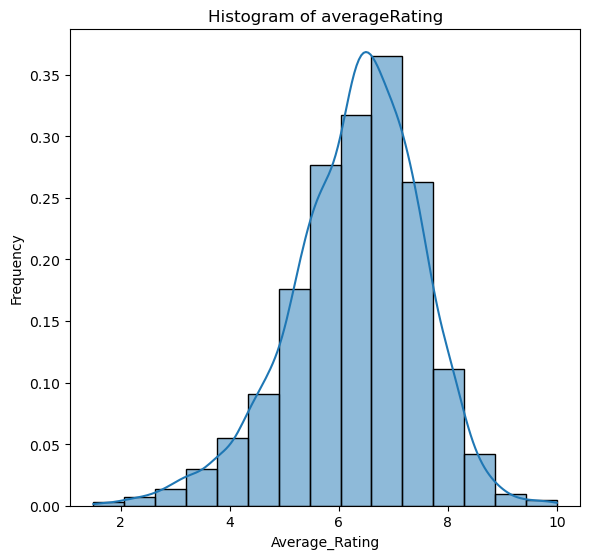

In [100]:
fig, ax = plt.subplots(figsize=(6, 6))

sns.histplot(streaming_df_copy, x="Average_Rating", kde=True, stat="density", ax=ax, bins=15)
ax.set_title("Histogram of averageRating")
ax.set_xlabel("Average_Rating")
ax.set_ylabel("Frequency")

plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()

The streaming ratings have a more balanced distribution than the movie dataframe. This contrast highlights different success metrics: streaming platforms rely on user ratings for a measure of success and box office movies are judged on revenue.
It's more relevant to study the success of a streaming movie based on ratings, we dont need necessarly to have the revenue.

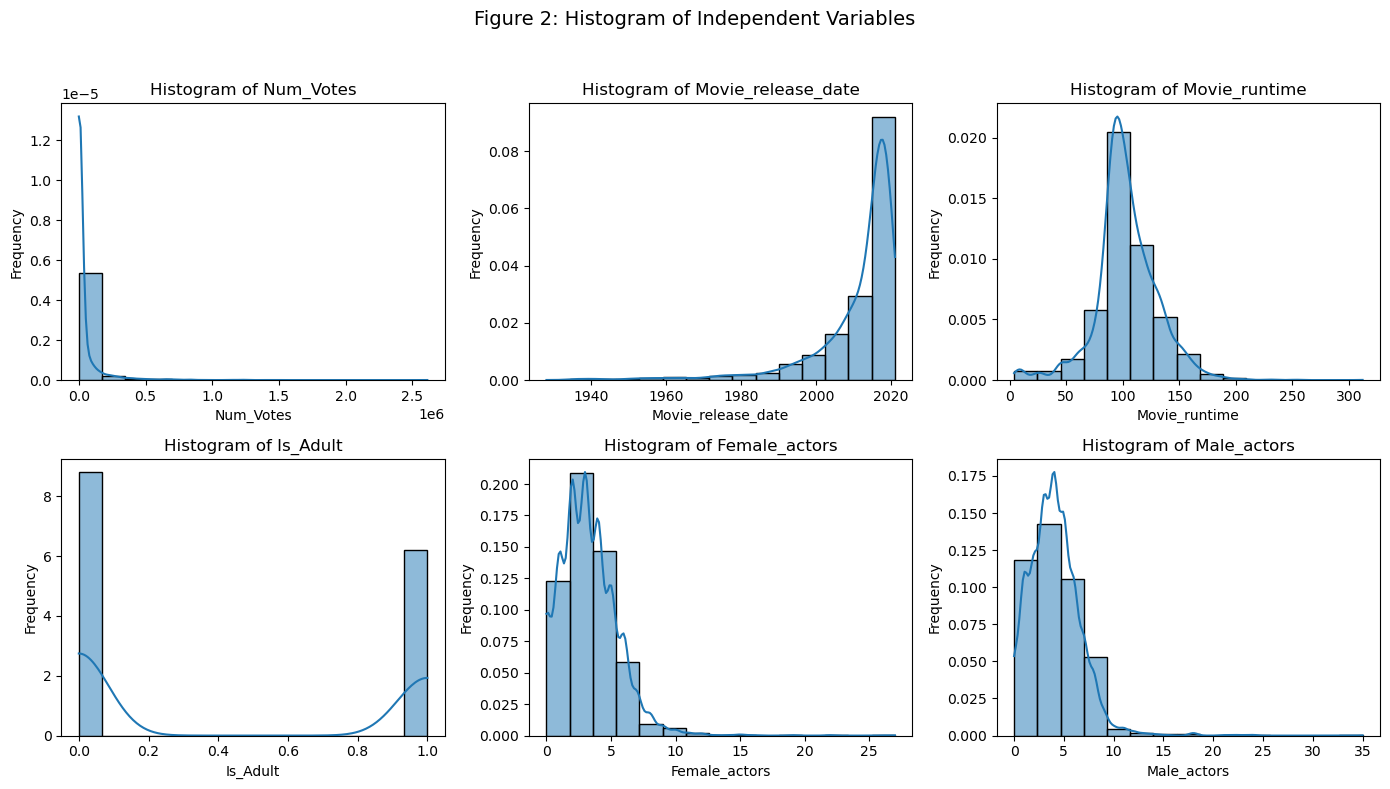

In [101]:

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 8))
fig.suptitle("Figure 2: Histogram of Independent Variables", fontsize=14)

axes = axes.flatten()

indep_var = ["Num_Votes", "Movie_release_date", "Movie_runtime", "Is_Adult", "Female_actors", "Male_actors"]

#Plot histograms for each independent variable
for i, col in enumerate(indep_var):
    sns.histplot(streaming_df_copy, x=col, kde=True, stat="density", ax=axes[i], bins=15)
    axes[i].set_title(f"Histogram of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Release_year : The majority of movies in the dataset are very recent with an increase after the year 2000.
Duration: The duration of most movies is between 90 and 120 minutes, which is typical for films.
Is_Adult: Most movies are not classified as adult content but we can see that there is an important proportion of movies classified as adult content.
Female_count and male_count: We can see that the number of men is greater than women but this difference is lower than for CMU/IMDB movies.



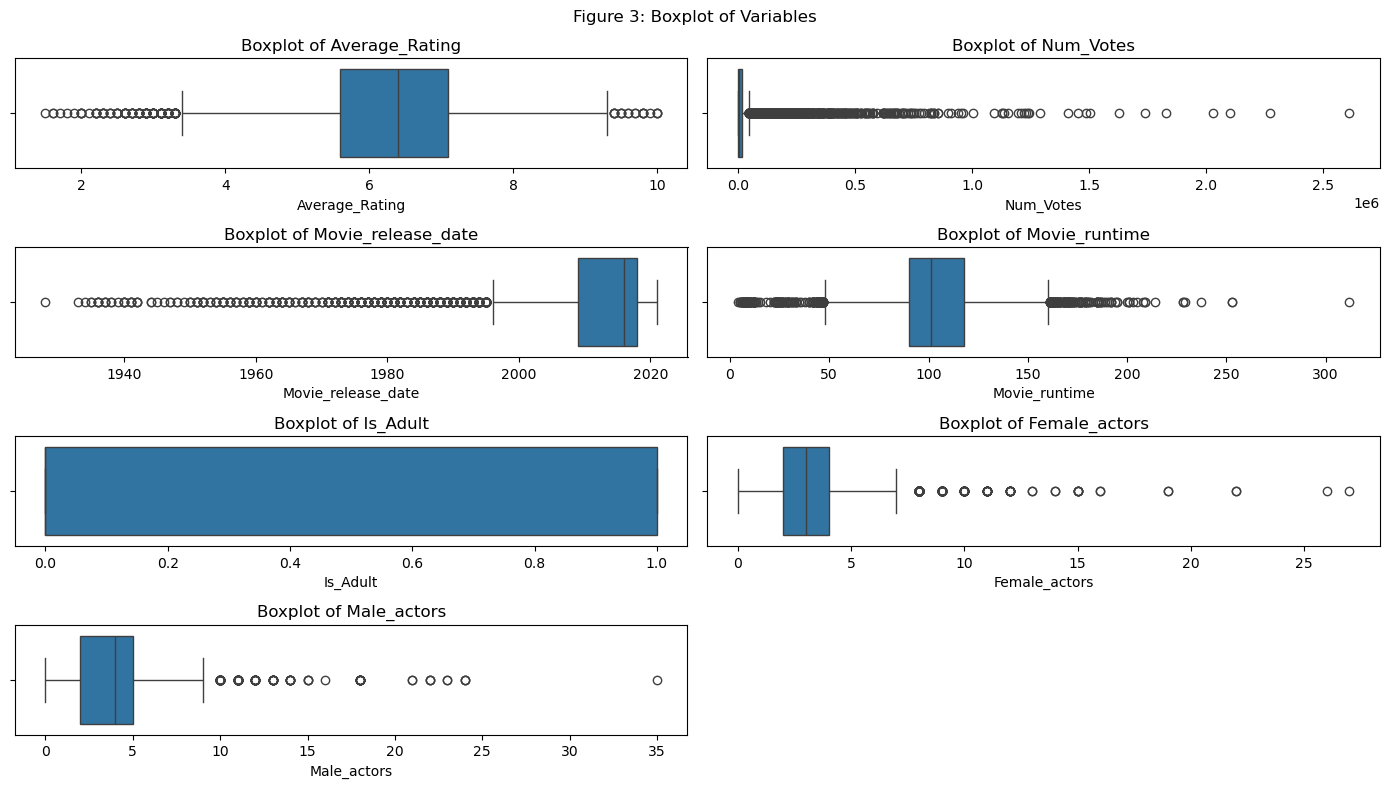

In [102]:
plt.figure(figsize=(14, 8))
for i, col in enumerate(numeric_columns_streaming, 1):
    plt.subplot(4, 2, i)
    sns.boxplot(data=streaming_df_copy, x=col)
    plt.title(f"Boxplot of {col}")
    
plt.suptitle("Figure 3: Boxplot of Variables")     
plt.tight_layout()
plt.show()

As we did in the previous part, we now have to focus on outliers and removing them for a more accurate modeling.

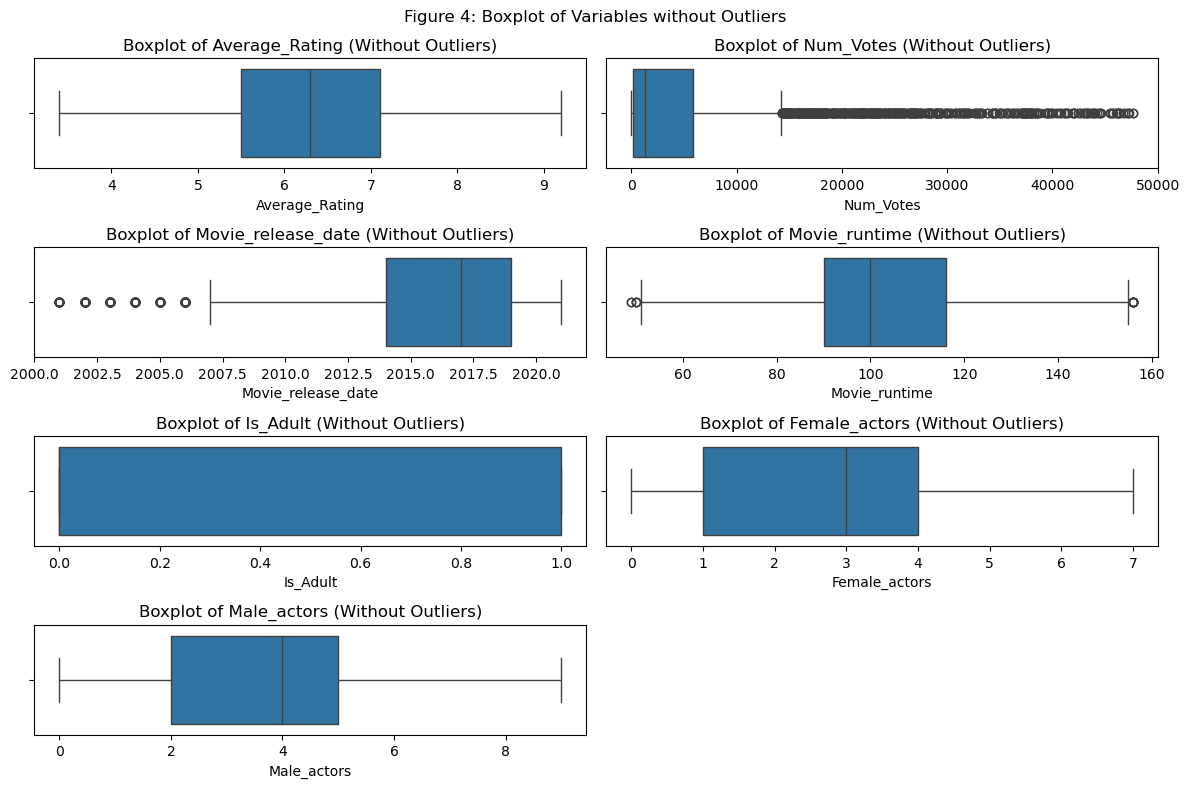

In [103]:
# Define a function to remove outliers based on IQR
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df


movie_df_no_outliers = remove_outliers(streaming_df_copy, numeric_columns_streaming)
plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_columns_streaming, 1):
    plt.subplot(4, 2, i)
    sns.boxplot(data=movie_df_no_outliers, x=col)
    plt.title(f"Boxplot of {col} (Without Outliers)")
plt.suptitle("Figure 4: Boxplot of Variables without Outliers")
plt.tight_layout()
plt.show()

In [104]:
print(f"After removing the outliers and dropping the null values, we are left with {len(movie_df_no_outliers):,} movies.")

After removing the outliers and dropping the null values, we are left with 4,159 movies.


##### 1.1.2 Bivariate Analysis
a. <u>Correlation matrix</u>:

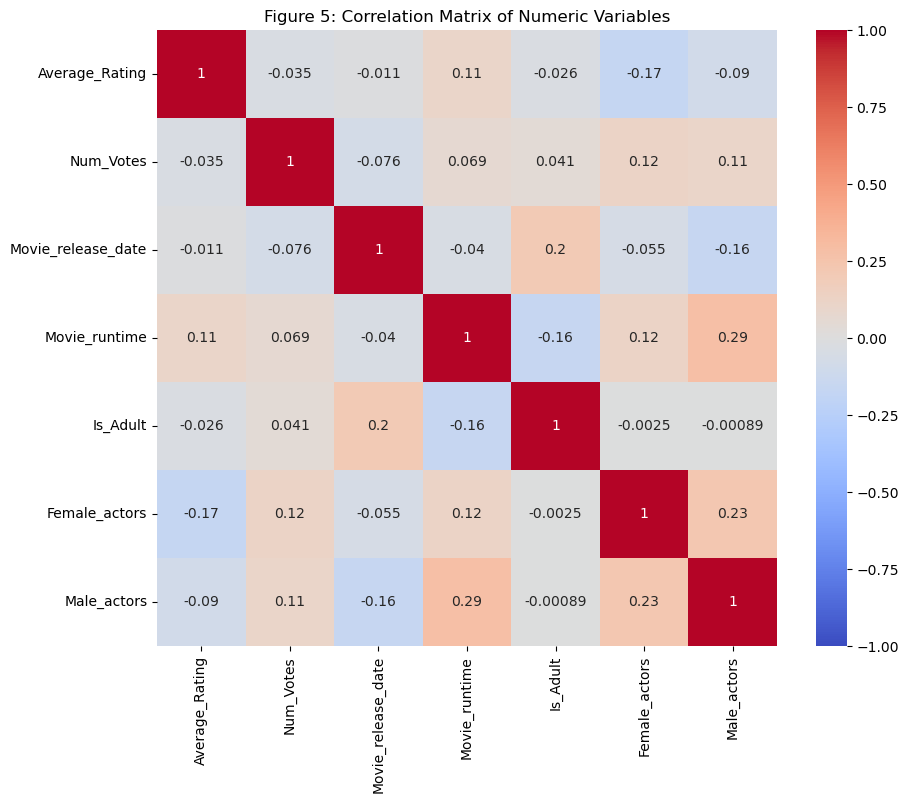

In [105]:
#correlation matrix
correlation_matrix = movie_df_no_outliers[numeric_columns_streaming].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Figure 5: Correlation Matrix of Numeric Variables")
plt.show()

The number of votes and gender composition (especially the number of male actors) seem to influence movie duration. It suggests that popularity and cast composition could impact movie production characteristics.
Weak correlations between movie duration and other variables indicate that duration might not strongly determine popularity based on votes.
This correlation matrix suggests further analysis like regression that could help separate and clarify the effects of gender and duration on popularity.

b. <u>Scatter plots </u>:

/opt/anaconda3/envs/ada/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


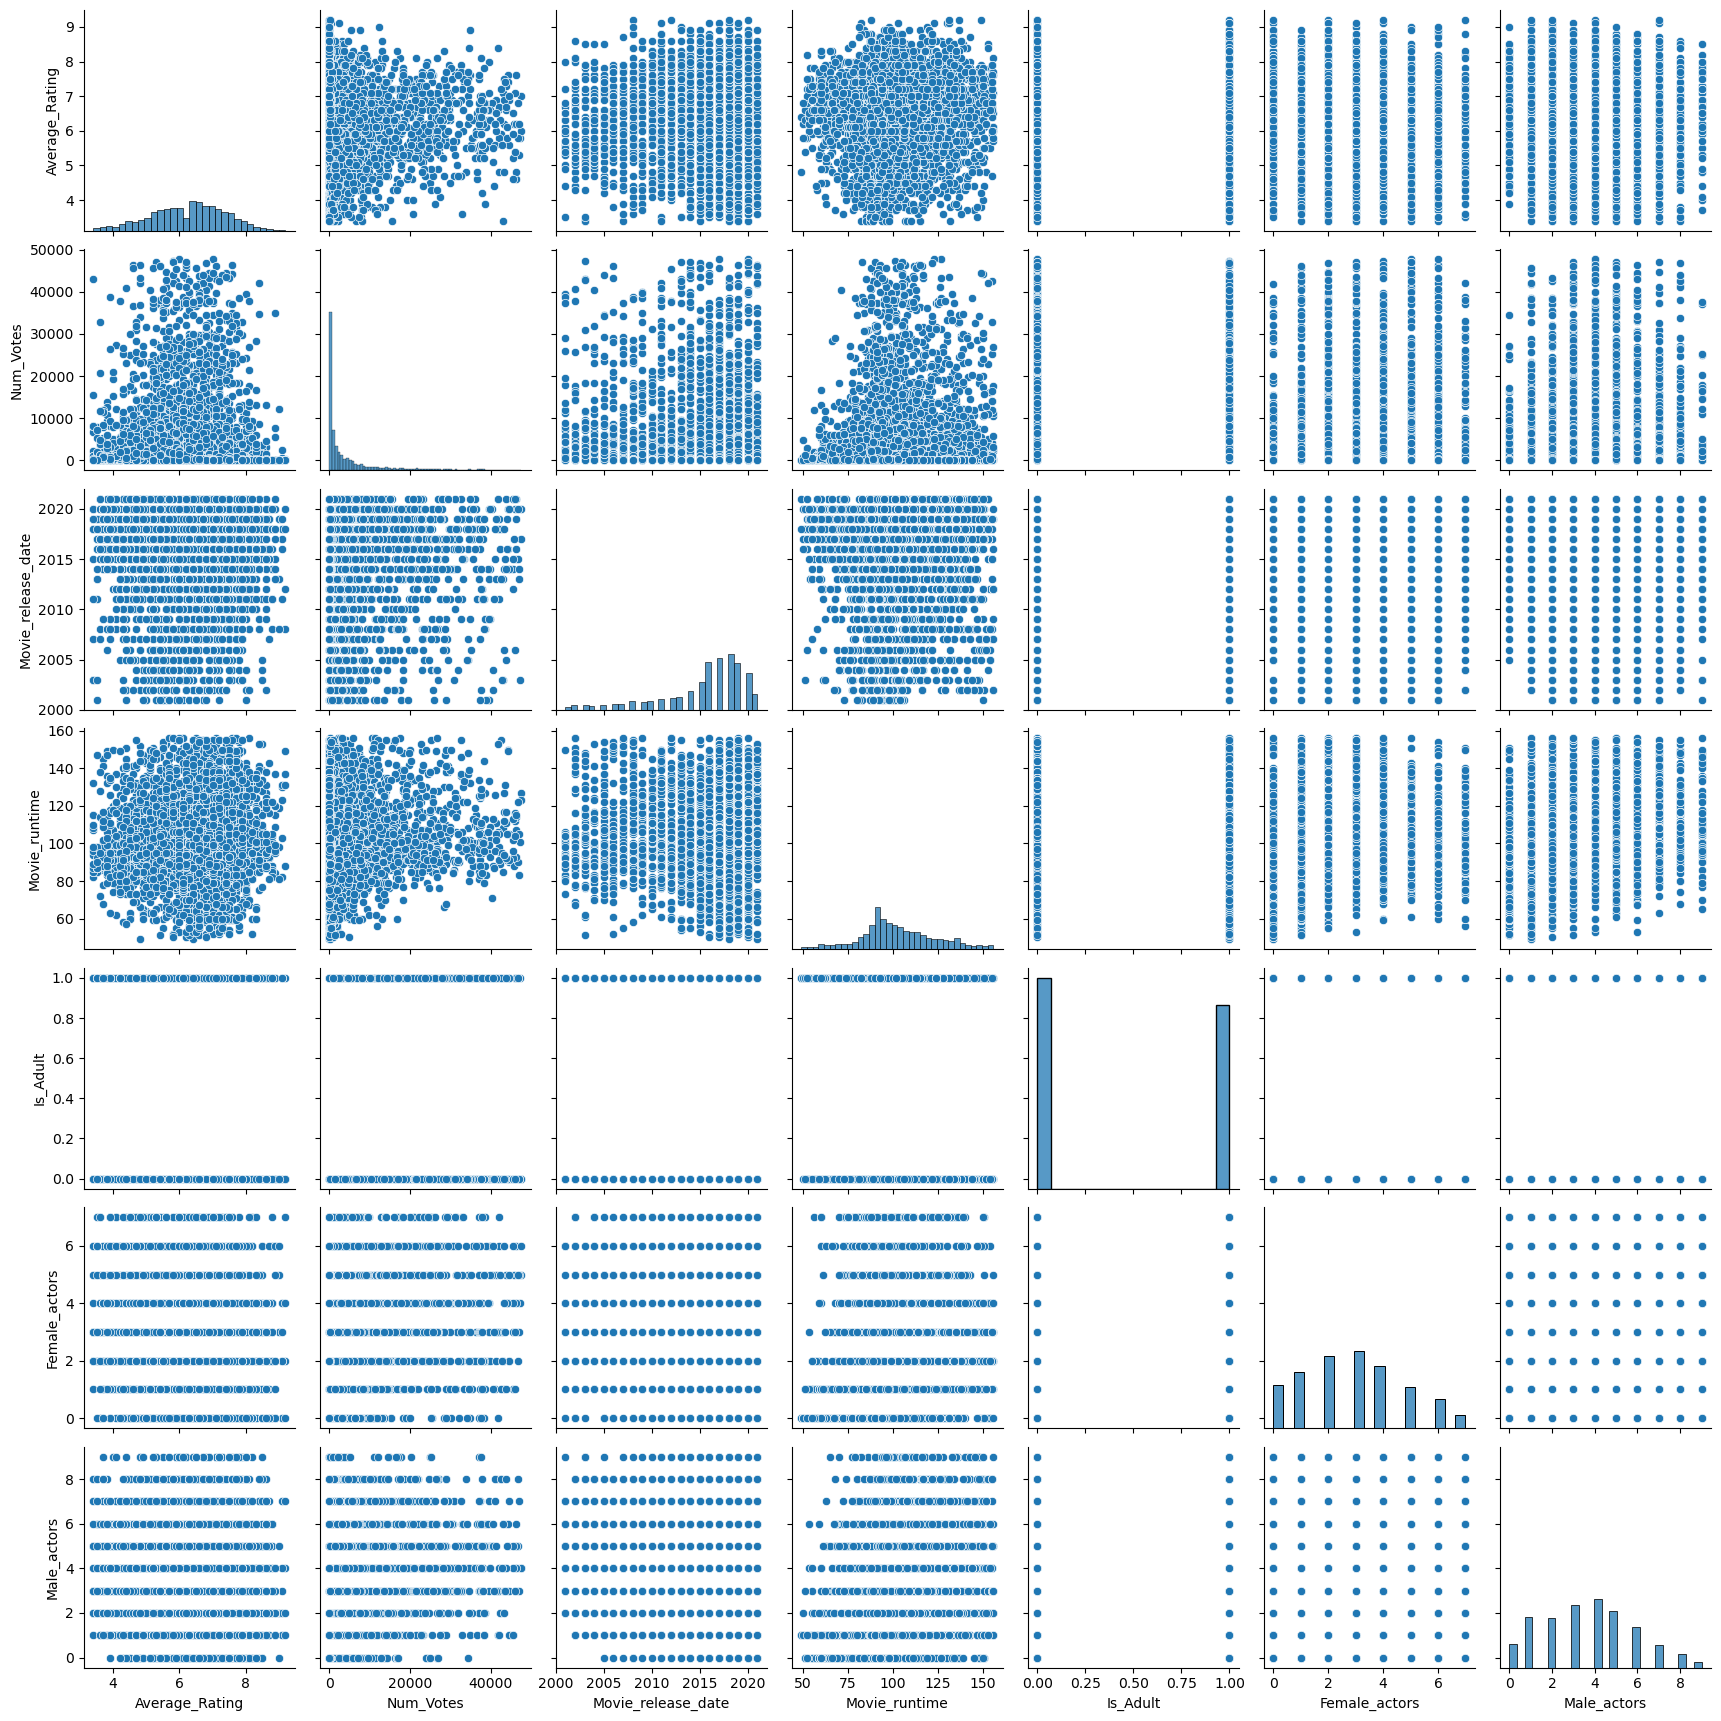

In [106]:
sns.pairplot(movie_df_no_outliers[numeric_columns_streaming])

### 5. <u>What are the social reasons behind the presence of female characters in movies? Is it due to sexualization or genuine equality of representation?</u>

The first part of our analysis uses plot summaries to examine whether female characters are portrayed as having agency (taking action and driving the story) or are reduced to sexualized or objectified roles. So far, we have used LLMs, such as ChatGPT Plus, to classify plot summaries based on these criteria (contains/does not contain sexualization of females), which provided useful initial results and validated the approach. However, due to time constraints during milestone 2, we were unable to use more advanced methods, such as zero-shot or few-shot learning with models like OpenAI's GPT-4, T5, or BERT variants, which we plan to explore further in milestone 3.
The second part of our analysis focuses on adult-rated films in the resulting merged dataframe, specifically examining the gender of the actors to understand patterns of representation.